In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy
from PDEsolvers import Burgers_Periodic

In [2]:
# User inputs
data_train_len = 20  # Number of training data files
data_name = 'Burgers_Eqn_exp28'  # Prefix of data files
folder_name = 'Burgers_exp30f/'  # Folder to be created for saved output

In [3]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])

Burgers_exp30f/Burgers_Eqn_exp30_2019_10_31_06_23_39_735564_model.pkl
0.03197038024663925
0.019574487581849098


In [4]:
# Create numpy arrays with data

# Use these lines to load all data
data_train = np.load(('./data/%s_train1_x.npy' % (data_name)))

data_test1 = np.load(('./data/%s_test1_x.npy' % data_name))
data_test2 = np.load(('./data/%s_test2_x.npy' % data_name))
data_test3 = np.load(('./data/%s_test3_x.npy' % data_name))
data_test4 = np.load(('./data/%s_test4_x.npy' % data_name))
data_test5 = np.load(('./data/%s_test5_x.npy' % data_name))
data_test_all = np.vstack([data_test1,data_test2,data_test3,data_test4,data_test5])


IOError: [Errno 2] No such file or directory: u'./data/Burgers_Eqn_exp28_test1_x.npy'

In [5]:
import helperfns_convnet

max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
data_train_tensor = helperfns_convnet.stack_data(data_train, max_shifts_to_stack, params['train_len_time'][0])
data_test1_tensor = helperfns_convnet.stack_data(data_test1, max_shifts_to_stack, params['val_len_time'])
data_test2_tensor = helperfns_convnet.stack_data(data_test2, max_shifts_to_stack, params['val_len_time'])
data_test3_tensor = helperfns_convnet.stack_data(data_test3, max_shifts_to_stack, params['val_len_time'])
data_test4_tensor = helperfns_convnet.stack_data(data_test4, max_shifts_to_stack, params['val_len_time'])
data_test5_tensor = helperfns_convnet.stack_data(data_test5, max_shifts_to_stack, params['val_len_time'])
data_test_all_tensor = helperfns_convnet.stack_data(data_test_all, max_shifts_to_stack, params['val_len_time'])

In [34]:
# Get all the needed things from the network

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for k in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(k)+"/outputs:0")
    #train_outputs = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
    # Encoded
    beg = 1
    end = max_shifts_to_stack+1
    tensor_list = ["encoder/vk_hat:0"]
    for k in np.arange(beg,end):
        tensor_list.append("encoder_"+str(k)+"/vk_hat:0") 
    #train_encoded = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_encoded = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
#train_outputs = np.asarray(train_outputs)
test_outputs = np.asarray(test_outputs)

#train_encoded = np.asarray(train_encoded)
test_encoded = np.asarray(test_encoded)


INFO:tensorflow:Restoring parameters from ./Burgers_exp30f/Burgers_Eqn_exp30_2019_10_31_06_23_39_735564_model.ckpt


In [7]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

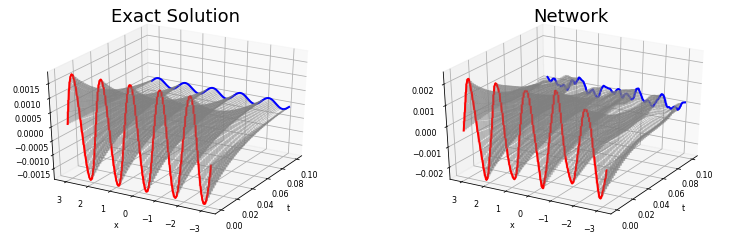

0.0065027453082599765


In [65]:
# Inputs
data = 'test'  # 'train', 'val', or 'test'
IC = 1638 # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_all_tensor


# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

fig = plt.figure(figsize=(13,4)) 

ax = fig.add_subplot(1, 2, 1, projection='3d')
#surf = ax.plot_surface(T, X, np.transpose(exact), cmap=plt.cm.coolwarm)
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
#surf = ax.plot_surface(T, X, np.transpose(outputs[:,ind,:]), cmap=plt.cm.coolwarm)
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize=18)

plt.show()
#plt.savefig(filename,format='eps')  

pred = outputs[:,IC,:]
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

# Prediction Plots

0.001403268091707096


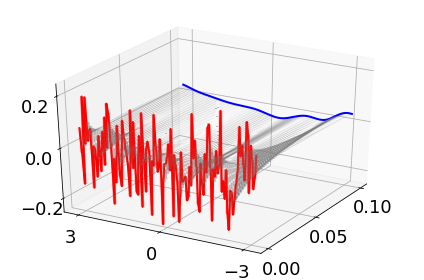

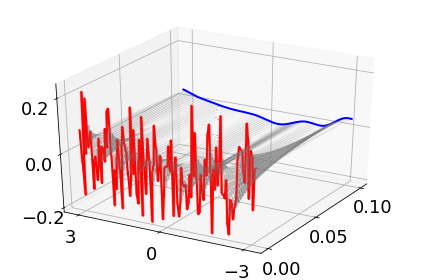

In [70]:
# Test data, IC = 0

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 0

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-0.2, 0, 0.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-0.2, 0, 0.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

pred = outputs[:,IC,:]
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

0.004082880110331551


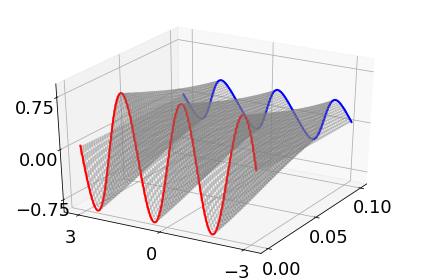

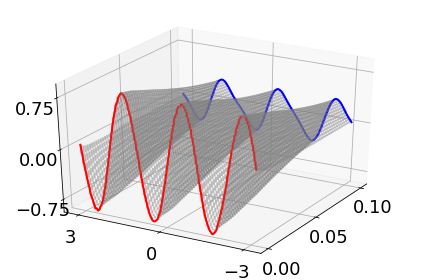

In [71]:
# Test data, IC = 1000

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1000

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-0.75, 0, 0.75])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-0.75, 0, 0.75])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

pred = outputs[:,IC,:]
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

0.0016712362403199944


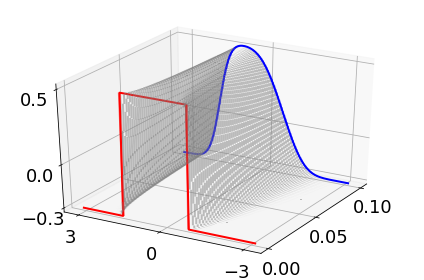

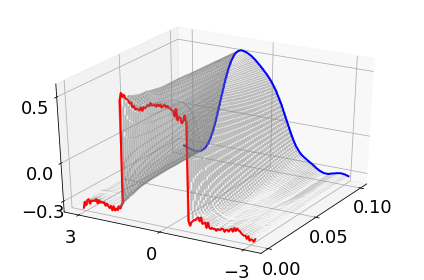

In [72]:
# Test data, IC = 2000

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 2000

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-0.3, 0, 0.5])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-0.3, 0, 0.5])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  


pred = outputs[:,IC,:]
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

0.03658397785417422


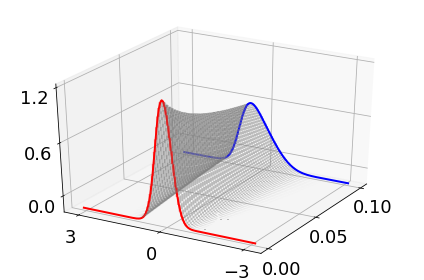

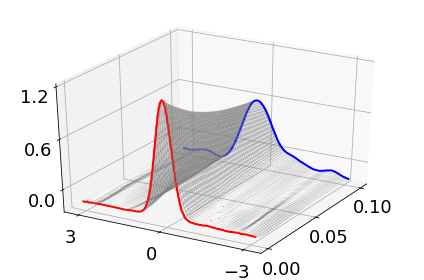

In [73]:
# Test data, IC = 3000

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3000

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([0, 0.6, 1.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([0, 0.6, 1.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

pred = outputs[:,IC,:]
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

0.003626730422604608


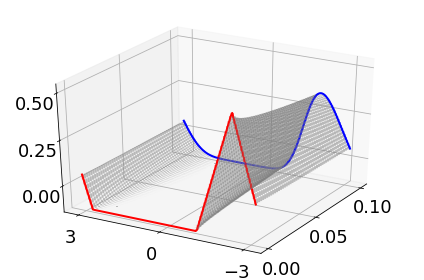

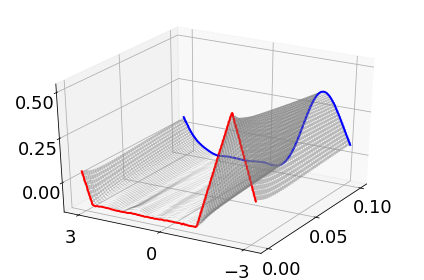

In [74]:
# Test data, IC = 4010

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4010

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([0, 0.25, 0.5])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([0, 0.25, 0.5])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

pred = outputs[:,IC,:]
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

# Prediction plots for comparison

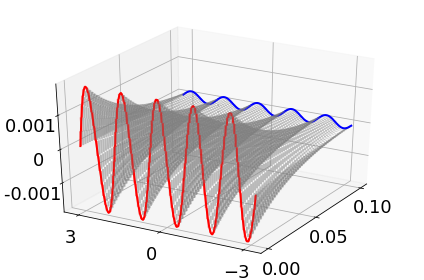

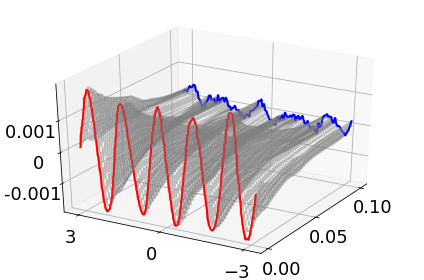

In [35]:
# Test data, IC = 1638

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1638

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-.001, 0, .001])
ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zticks([-.001, 0, .001])
ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

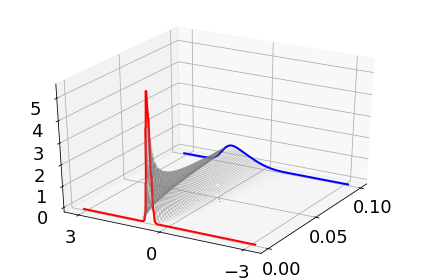

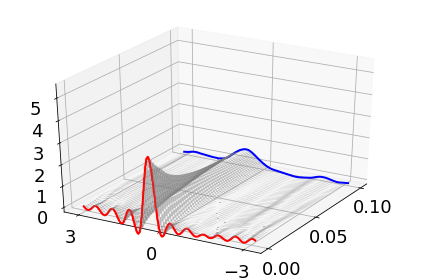

In [36]:
# Test data, IC = 3442

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3442

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zlim3d(-.1, 5.5)  
#ax.set_zticks([-.001, 0, .001])
#ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zlim3d(-.1, 5.5)  
#ax.set_zticks([-.001, 0, .001])
#ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

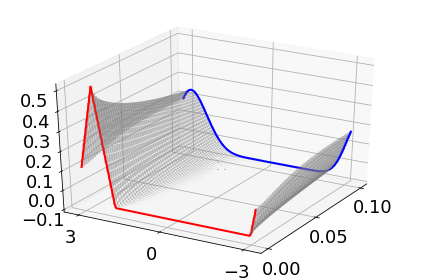

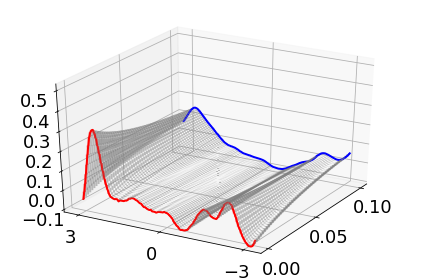

In [37]:
# Test data, IC = 4300

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4300

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zlim3d(-.1, .52)  
#ax.set_zticks([-.001, 0, .001])
#ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zlim3d(-.1, .52)  
#ax.set_zticks([-.001, 0, .001])
#ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

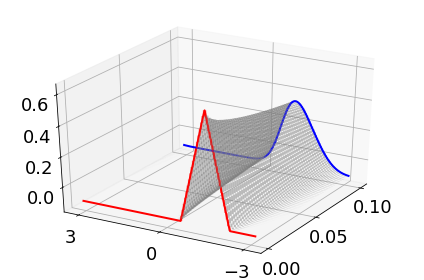

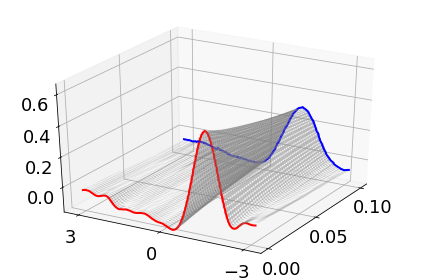

In [38]:
# Test data, IC = 4254

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4254

# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zlim3d(-.15, .65)  
#ax.set_zticks([-.001, 0, .001])
#ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks([0,0.05,0.1],fontsize=18)
plt.yticks([-3,0,3],fontsize=18)
ax.set_zlim3d(-.15, .65)  
#ax.set_zticks([-.001, 0, .001])
#ax.set_zticklabels(['-0.001   ','0','0.001  '])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

# Plot prediction loss for different types of data


In [6]:
# Check prediction losses for all types of test data
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    test1_loss = sess.run("loss2:0", feed_dict={"x:0": data_test1_tensor})
    test2_loss = sess.run("loss2:0", feed_dict={"x:0": data_test2_tensor})
    test3_loss = sess.run("loss2:0", feed_dict={"x:0": data_test3_tensor})
    test4_loss = sess.run("loss2:0", feed_dict={"x:0": data_test4_tensor})
    test5_loss = sess.run("loss2:0", feed_dict={"x:0": data_test5_tensor})
            
print(test1_loss)
print(test2_loss)
print(test3_loss)
print(test4_loss)
print(test5_loss)


INFO:tensorflow:Restoring parameters from ./Burgers_exp28nn/Burgers_Eqn_exp28_2019_10_28_03_39_08_994521_model.ckpt
0.008320378
0.00083304883
0.001179815
0.020276599
0.00093804504


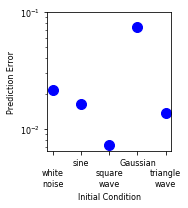

In [10]:
x_vals = np.arange(5)
y_vals = np.array([test1_loss, test2_loss, test3_loss, test4_loss, test5_loss])

plt.figure(figsize=(2.7,3))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.yscale("log")
plt.plot(x_vals,y_vals,'ob',markersize=10)
plt.xticks(x_vals, ['\nwhite\nnoise','sine','\nsquare\nwave','Gaussian','\ntriangle\nwave'])
plt.yticks([10**(-2), 10**(-1)])
plt.xlabel("Initial Condition")
plt.ylabel("Prediction Error")
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/data_reducedcnn.eps' 
plt.savefig(filename,format='eps')  

INFO:tensorflow:Restoring parameters from ./Burgers_exp28rr/Burgers_Eqn_exp28_2019_10_30_12_36_21_007819_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp30e/Burgers_Eqn_exp30_2019_10_31_06_23_27_317592_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp32e/Burgers_Eqn_exp32_2019_10_31_06_23_48_503042_model.ckpt


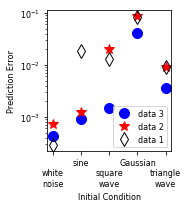

In [9]:
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best


x_vals = np.arange(5)
line_styles = ["ob","*r","dk"]
fill_styles = ['full','full','none']
folder_names = ['Burgers_exp28rr/','Burgers_exp30e/','Burgers_exp32e/']

plt.figure(figsize=(2.7,3))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.yscale("log")

lines = []
for k in range(3):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(params['model_path']+'.meta')
        saver.restore(sess, params['model_path'])
    
        test1_loss = sess.run("loss2:0", feed_dict={"x:0": data_test1_tensor})
        test2_loss = sess.run("loss2:0", feed_dict={"x:0": data_test2_tensor})
        test3_loss = sess.run("loss2:0", feed_dict={"x:0": data_test3_tensor})
        test4_loss = sess.run("loss2:0", feed_dict={"x:0": data_test4_tensor})
        test5_loss = sess.run("loss2:0", feed_dict={"x:0": data_test5_tensor})
        
        
    y_vals = np.array([test1_loss, test2_loss, test3_loss, test4_loss, test5_loss])

    lines += plt.plot(x_vals,y_vals,line_styles[k],fillstyle=fill_styles[k],markersize=10)
    
plt.xticks(x_vals, ['\nwhite\nnoise','sine','\nsquare\nwave','Gaussian','\ntriangle\nwave'])
plt.yticks([10**(-3),10**(-2), 10**(-1)])
plt.xlabel("Initial Condition")
plt.ylabel("Prediction Error")
plt.legend(lines,['data 3','data 2','data 1'],fontsize=8)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/data_fullwidth.eps' 
plt.savefig(filename,format='eps')  
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp28ss/Burgers_Eqn_exp28_2019_10_30_16_51_54_151793_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp30f/Burgers_Eqn_exp30_2019_10_31_06_23_39_735564_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp32f/Burgers_Eqn_exp32_2019_10_31_06_23_54_058129_model.ckpt


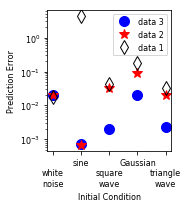

In [10]:
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best


x_vals = np.arange(5)
line_styles = ["ob","*r","dk"]
fill_styles = ['full','full','none']
folder_names = ['Burgers_exp28ss/','Burgers_exp30f/','Burgers_exp32f/']

plt.figure(figsize=(2.7,3))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.yscale("log")

lines = []
for k in range(3):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(params['model_path']+'.meta')
        saver.restore(sess, params['model_path'])
    
        test1_loss = sess.run("loss2:0", feed_dict={"x:0": data_test1_tensor})
        test2_loss = sess.run("loss2:0", feed_dict={"x:0": data_test2_tensor})
        test3_loss = sess.run("loss2:0", feed_dict={"x:0": data_test3_tensor})
        test4_loss = sess.run("loss2:0", feed_dict={"x:0": data_test4_tensor})
        test5_loss = sess.run("loss2:0", feed_dict={"x:0": data_test5_tensor})
        
        
    y_vals = np.array([test1_loss, test2_loss, test3_loss, test4_loss, test5_loss])

    lines += plt.plot(x_vals,y_vals,line_styles[k],fillstyle=fill_styles[k],markersize=10)
    
plt.xticks(x_vals, ['\nwhite\nnoise','sine','\nsquare\nwave','Gaussian','\ntriangle\nwave'])
plt.yticks([10**(-3),10**(-2),10**(-1), 10**(0)])
plt.xlabel("Initial Condition")
plt.ylabel("Prediction Error")
plt.legend(lines,['data 3','data 2','data 1'],fontsize=8)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/data_reduce.eps' 
plt.savefig(filename,format='eps')  
    

# ROM Figure

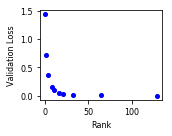

In [15]:
x_vals = np.array([1,2,4,8,11,16,21,32,64,128])
y_vals = np.zeros(10)

folder_names = ['Burgers_exp28_ROM1/','Burgers_exp28_ROM2/','Burgers_exp28_ROM4/','Burgers_exp28_ROM8/','Burgers_exp28_ROM11/']
folder_names = folder_names + ['Burgers_exp28_ROM16/','Burgers_exp28ss/','Burgers_exp28_ROM32/','Burgers_exp28_ROM64/','Burgers_exp28rr/']

for k in range(10):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    y_vals[k] = params['minTest']

plt.figure(figsize=(2.5,2))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.plot(x_vals,y_vals,'ob',markersize=4)
plt.xlabel("Rank")
plt.ylabel("Validation Loss")
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/ROM_linear.eps' 
plt.savefig(filename,format='eps')  

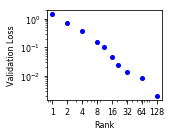

In [14]:
x_vals = np.array([1,2,4,8,11,16,21,32,64,128])
y_vals = np.zeros(10)

folder_names = ['Burgers_exp28_ROM1/','Burgers_exp28_ROM2/','Burgers_exp28_ROM4/','Burgers_exp28_ROM8/','Burgers_exp28_ROM11/']
folder_names = folder_names + ['Burgers_exp28_ROM16/','Burgers_exp28ss/','Burgers_exp28_ROM32/','Burgers_exp28_ROM64/','Burgers_exp28rr/']

for k in range(10):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    y_vals[k] = params['minTest']

plt.figure(figsize=(2.5,2))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.plot(x_vals,y_vals,'ob',markersize=4)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Rank")
plt.ylabel("Validation Loss")
plt.xticks(2**(np.arange(8)))
ax = plt.gca()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/ROM_log.eps' 
plt.savefig(filename,format='eps')  

# Plotting Eigenvalues and Eigenfunctions

In [21]:
lam, V = np.linalg.eig(L_mat)
lam = np.log(lam)
ind = np.argsort(lam)
ind = np.flip(ind,0)
lam = np.sort(lam)
lam = np.flip(lam,0)
network_lam = lam/params['delta_t']
print(lam/params['delta_t'])

[-9.33495834e-02 -1.15199246e-01 -1.00421357e+00 -4.27705240e+00
 -5.17509985e+00 -5.25210333e+00 -5.44181633e+00 -9.04420567e+00
 -1.08033772e+01 -1.22126360e+01 -1.29068775e+01 -2.16642437e+01
 -2.50691967e+01 -2.96098080e+01 -3.59148064e+01 -4.88137016e+01
 -4.88966103e+01 -6.36260910e+01 -6.36803551e+01 -8.00958099e+01
 -9.91848373e+01]


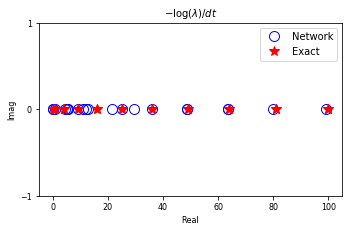

In [22]:
exact_lam = 0*lam

for k in np.arange(10):
    exact_lam[2*k+1:2*k+3] = [-(k+1)**2,-(k+1)**2]

plt.figure(figsize=(5,3.33))
Network, = plt.plot(-np.real(network_lam),np.imag(network_lam),'ob',markersize=10,markerfacecolor="None")
Exact, = plt.plot(-np.real(exact_lam),np.imag(exact_lam),'*r',markersize=10)
plt.ylim(-1,1)
#plt.xlim(0,105)
plt.yticks([-1,0,1])
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.title('$-\log(\lambda)/dt$',fontsize=10)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.legend([Network,Exact],['Network','Exact'],fontsize=10)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_eigs.eps'
#plt.savefig(filename,format='eps') 
plt.show()

In [13]:
# Create just the decoder
import networkarch as net

tf.reset_default_graph()

n_middle=params['n_middle']
x = tf.placeholder(tf.float32, shape=[None, n_middle], name="x")

if params['initialization'] == 'identity':
    initialization = net.identity_initializer()
elif params['initialization'] == 'He':
    initialization = tf.contrib.layers.variance_scaling_initializer()
else: 
    raise ValueError("Error, initialization must be either identity or He")

if params['network_arch'] == 'convnet':
    y = net.decoder_apply_cn(x, n_middle=params['n_middle'], conv2_filters=params['conv2_filters'], 
                             n_outputs=params['n_outputs'], L1_lam = params['L1_lam'], L2_lam=params['L2_lam'], 
                             reuse=False, fix_middle=params['fix_middle'], seed_middle=params['seed_middle'], 
                             add_identity=params['add_identity'], initialization=initialization)
elif params['network_arch'] == 'fully_connected':
    y = net.decoder_apply_fc(x, widths=params['widths'], linear_decoder_layers=params['linear_decoder_layers'], 
                             act_type=params['act_type'], log_space=params['log_space'], L1_lam = params['L1_lam'], 
                             L2_lam=params['L2_lam'], reuse=False, fix_middle=params['fix_middle'], 
                             seed_middle=params['seed_middle'], add_identity=params['add_identity'], 
                             num_decoder_weights=params['num_decoder_weights'], initialization=initialization)
else: 
    raise ValueError("Error, network_arch must be either convnet or fully_connected")
    
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, params['model_path'])
    
    inputs = V.T
    decoded_list = sess.run(y, feed_dict={"x:0": inputs})
    decoded_list = np.asarray(decoded_list)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28mm/Burgers_Eqn_exp28_2019_10_23_16_34_08_961958_model.ckpt


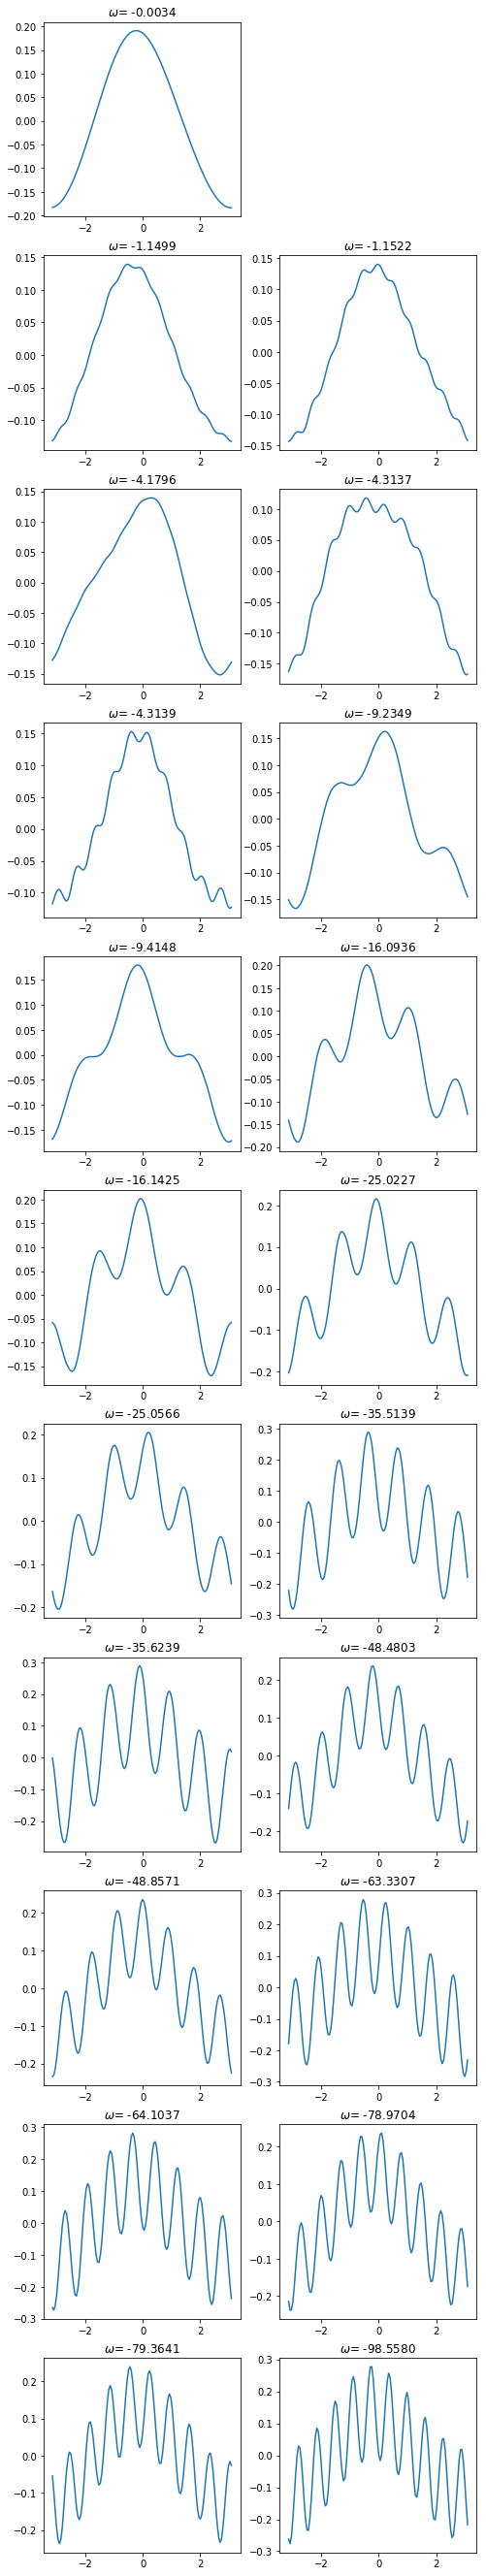

In [14]:
# Plot eigenvectors
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

f = decoded_list
f = np.real(f)

scale = np.zeros((21))
fig = plt.figure(figsize=(8,48)) 

ax = fig.add_subplot(11, 2, 1)
ax.plot(x_pts,f[ind[0],:])
ax.title.set_text('$\omega$= %6.4f' % network_lam[0])
scale[0] = np.linalg.norm(f[ind[0]])

for k in np.arange(10):
    ax = fig.add_subplot(11, 2, 2*k+3)
    ax.plot(x_pts,f[ind[2*k+1],:])
    ax.title.set_text('$\omega$= %6.4f' % network_lam[2*k+1])
    scale[2*k+1] = np.linalg.norm(f[ind[2*k+1],:])
    
    ax = fig.add_subplot(11, 2, 2*k+4)
    ax.plot(x_pts,f[ind[2*k+2],:])
    ax.title.set_text('$\omega$= %6.4f' % network_lam[2*k+2])
    scale[2*k+2] = np.linalg.norm(f[ind[2*k+2],:])
plt.show()

# Simulating for more time steps than the network was trained for

In [8]:
# Set parameters
eps = 10.0 # strength of advection
mu = 1.0 # viscosity in Burgers'
L = 2*np.pi # Length of domain
dt = 0.02 # Size of time step for data
n_time = 101 # Number of time steps
T = dt*(n_time-1)  # End time
dt_factor = 1000 # Divide dt by this factor for numerical stability when solving

#Choose some initial condition
IC = 0
test_encoded = train_encoded
data_test_all_tensor = data_train_tensor
u0 = data_test_all_tensor[0,IC,:]

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0,T,n_time)
T, X = np.meshgrid(t_pts,x_pts)

exact = Burgers_Periodic(mu,eps,x_pts,t_pts,dt_factor,u0)   

# Multiply initial conditions by L_mat to move forward in time
test_encoded_pred = np.zeros((n_time,np.shape(test_encoded)[2]))

current_time = test_encoded[0,IC,:]

for n_step in xrange(n_time):
    test_encoded_pred[n_step,:] = current_time
    current_time = np.matmul(current_time,L_mat)

In [9]:
# Decode
import networkarch4 as net

tf.reset_default_graph()

n_middle=params['num_evals']
x = tf.placeholder(tf.float32, shape=[None, n_middle], name="x")

if params['initialization'] == 'identity':
    initialization = net.identity_initializer()
elif params['initialization'] == 'He':
    initialization = tf.contrib.layers.variance_scaling_initializer()
else: 
    raise ValueError("Error, initialization must be either identity or He")

if params['network_arch'] == 'convnet':
    y = net.decoder_apply_cn(x, n_middle=params['n_middle'], conv2_filters=params['conv2_filters'], 
                             n_outputs=params['n_outputs'], L1_lam = params['L1_lam'], L2_lam=params['L2_lam'], 
                             reuse=False, fix_middle=params['fix_middle'], seed_middle=params['seed_middle'], 
                             add_identity=params['add_identity'], initialization=initialization)
elif params['network_arch'] == 'fully_connected':
    y = net.decoder_apply_fc(x, widths=params['widths'], linear_decoder_layers=params['linear_decoder_layers'], 
                             act_type=params['act_type'], log_space=params['log_space'], L1_lam = params['L1_lam'], 
                             L2_lam=params['L2_lam'], reuse=False, fix_middle=params['fix_middle'], 
                             seed_middle=params['seed_middle'], add_identity=params['add_identity'], 
                             num_decoder_weights=params['num_decoder_weights'], initialization=initialization)
else: 
    raise ValueError("Error, network_arch must be either convnet or fully_connected")
    
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, params['model_path'])
    
    inputs = test_encoded_pred
    decoded_list = sess.run(y, feed_dict={"x:0": inputs})
    decoded_list = np.asarray(decoded_list)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28dd/Burgers_Eqn_exp28_2019_10_02_16_31_15_670698_model.ckpt


InvalidArgumentError: Incompatible shapes: [202,128] vs. [101,128]
	 [[Node: decoder_outer/outputs = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](decoder_outer/hidden4_decode/BiasAdd, decoder_outer/mul)]]

Caused by op u'decoder_outer/outputs', defined at:
  File "/anaconda3/envs/tensorflow/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/anaconda3/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 1017, in start
    self._run_callback(self._callbacks.popleft())
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-3babf73eedeb>", line 20, in <module>
    add_identity=params['add_identity'], initialization=initialization)
  File "networkarch4.py", line 135, in decoder_apply_cn
    output = outer_decoder_apply_cn(prev_layer, conv2_filters, n_outputs, L1_lam, L2_lam, reuse, add_identity, initialization)
  File "networkarch4.py", line 173, in outer_decoder_apply_cn
    output = tf.add(hidden4_decode,tf.scalar_mul(identity_weight, x), name="outputs")
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 297, in add
    "Add", x=x, y=y, name=name)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [202,128] vs. [101,128]
	 [[Node: decoder_outer/outputs = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](decoder_outer/hidden4_decode/BiasAdd, decoder_outer/mul)]]


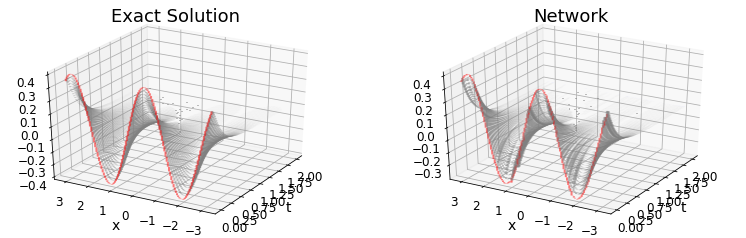

In [31]:
fig = plt.figure(figsize=(13,4)) 

ax = fig.add_subplot(1, 2, 1, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=n_time-1,linewidth=2,alpha=.5) 
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(decoded_list),time_in=0,time_out=n_time-1,linewidth=2,alpha=.5) 
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize=18)

plt.show() 

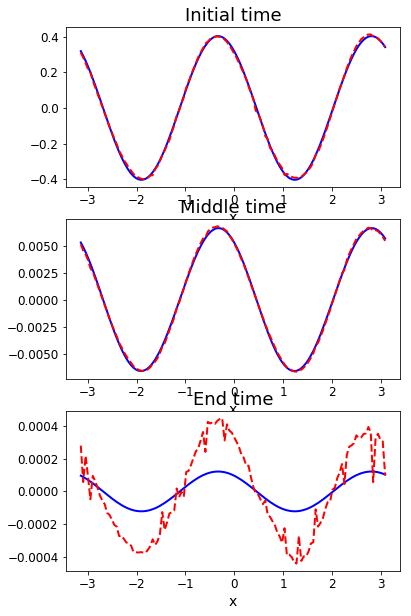

In [32]:
fig = plt.figure(figsize=(6,10)) 

ax = fig.add_subplot(3, 1, 1)
ax.plot(x_pts,exact[0,:],'-b',linewidth=2) 
ax.plot(x_pts,decoded_list[0,:],'--r',linewidth=2) 
ax.set_xlabel('x')
ax.set_title('Initial time', fontsize=18)

ax = fig.add_subplot(3, 1, 2)
ax.plot(x_pts,exact[50,:],'-b',linewidth=2) 
ax.plot(x_pts,decoded_list[50,:],'--r',linewidth=2) 
ax.set_xlabel('x')
ax.set_title('Middle time', fontsize=18)

ax = fig.add_subplot(3, 1, 3)
ax.plot(x_pts,exact[-1,:],'-b',linewidth=2) 
ax.plot(x_pts,decoded_list[-1,:],'--r',linewidth=2) 
ax.set_xlabel('x')
ax.set_title('End time', fontsize=18)

plt.show() 

# Check different losses


In [26]:
# Check prediction losses for all types of test data
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    loss1 = sess.run("loss1:0", feed_dict={"x:0": data_train_tensor})
    loss2 = sess.run("loss2:0", feed_dict={"x:0": data_train_tensor})
    loss3 = sess.run("loss3:0", feed_dict={"x:0": data_train_tensor})
    loss4 = sess.run("loss4:0", feed_dict={"x:0": data_train_tensor})
    loss5 = sess.run("loss5:0", feed_dict={"x:0": data_train_tensor})
            
print(loss1)
print(loss2)
print(loss3)
print(loss4)
print(loss5)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28i/Burgers_Eqn_exp28_2019_08_02_07_30_15_766251_model.ckpt
0.021427684
0.017556638
0.0017315636
0.00251304
0.00041812443


# Plot Cole-Hopf

In [15]:
# Get partially encoded
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Partially  Encoded
    beg = 1
    end = max_shifts_to_stack+1
    tensor_list = ["encoder/v_k:0"]
    for k in np.arange(beg,end):
        tensor_list.append("encoder_"+str(k)+"/v_k:0") 
    train_partiallyencoded = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_partiallyencoded = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
train_partiallyencoded = np.asarray(train_partiallyencoded)
test_partiallyencoded = np.asarray(test_partiallyencoded)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28rr/Burgers_Eqn_exp28_2019_10_30_12_36_21_007819_model.ckpt


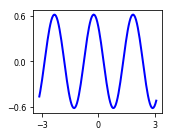

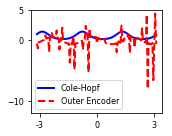

In [16]:
# Plot for IC = 1002
from scipy.integrate import cumtrapz

# Inputs
eps = 10
mu = 1
IC = 1002    # index of initial condition

partially_encoded = test_partiallyencoded
data_tensor = data_test_all_tensor

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]  
    
f = data_tensor[0,IC,:]
int_vec = cumtrapz(f, x_pts, initial=0)
v = np.exp(-eps*int_vec/(2*mu))

plt.figure(figsize=(2.5,2))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.plot(x_pts, data_tensor[0,IC,:], "b-", linewidth=2)
plt.xticks([-3,0,3])
plt.yticks([-0.6,0,0.6])
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_CH_testIC' + str(IC) + 'input.eps'
plt.savefig(filename,format='eps')  

plt.figure(figsize=(2.5,2))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.plot(x_pts, v, "b-", linewidth=2)
plt.plot(x_pts, partially_encoded[0,IC,:], "r--", linewidth=2)
plt.xticks([-3,0,3],["-3","0","3"])
plt.yticks([-10,0,5])
plt.ylim([-12,5])
plt.legend(['Cole-Hopf','Outer Encoder'],fontsize=8)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_CH_testIC' + str(IC) + 'partEncoded.eps'
plt.savefig(filename,format='eps')  


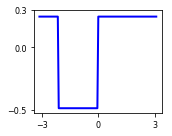

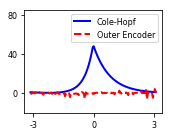

In [17]:
# Plot for IC = 2004
from scipy.integrate import cumtrapz

# Inputs
eps = 10
mu = 1
IC = 2004    # index of initial condition

partially_encoded = test_partiallyencoded
data_tensor = data_test_all_tensor

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]  
    
f = data_tensor[0,IC,:]
int_vec = cumtrapz(f, x_pts, initial=0)
v = np.exp(-eps*int_vec/(2*mu))

plt.figure(figsize=(2.5,2))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.plot(x_pts, data_tensor[0,IC,:], "b-", linewidth=2)
plt.xticks([-3,0,3])
plt.yticks([-0.5,0,0.3])
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_CH_testIC' + str(IC) + 'input.eps'
plt.savefig(filename,format='eps')  

plt.figure(figsize=(2.5,2))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.plot(x_pts, v, "b-", linewidth=2)
plt.plot(x_pts, partially_encoded[0,IC,:], "r--", linewidth=2)
plt.xticks([-3,0,3],["-3","0","3"])
plt.yticks([0,40,80])
plt.ylim([-20,85])
plt.legend(['Cole-Hopf','Outer Encoder'],fontsize=8)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_CH_testIC' + str(IC) + 'partEncoded.eps'
plt.savefig(filename,format='eps')  


# Total Loss on test data

In [7]:
# Check prediction losses for all types of test data
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    test_loss, test_predloss = sess.run(["loss:0","loss2:0"], feed_dict={"x:0": data_test_all_tensor})
            
print(test_loss)
print(test_predloss)


INFO:tensorflow:Restoring parameters from ./Burgers_exp28d/Burgers_Eqn_exp28_2019_08_02_04_48_16_256052_model.ckpt
0.017538868
0.01466484


In [89]:
# Check losses for all types of test data
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    #test_loss, test_loss1, test_loss2, test_loss3, test_loss4, test_loss5 = sess.run(["loss:0","loss1:0","loss2:0","loss3:0","loss4:0","loss5:0"], feed_dict={"x:0": data_test_all_tensor[:,:3000,:]})
            
    #print(test_loss)
    #print(test_loss1)
    #print(test_loss2)
    #print(test_loss3)
    #print(test_loss4)
    #print(test_loss5)
    
    #test_loss, test_loss1, test_loss2, test_loss3, test_loss4, test_loss5 = sess.run(["loss:0","loss1:0","loss2:0","loss3:0","loss4:0","loss5:0"], feed_dict={"x:0": data_test_all_tensor[:,3000:,:]})
            
    #print(test_loss)
    #print(test_loss1)
    #print(test_loss2)
    #print(test_loss3)
    #print(test_loss4)
    #print(test_loss5)
    
    test_loss, test_loss1, test_loss2, test_loss3, test_loss4, test_loss5 = sess.run(["loss:0","loss1:0","loss2:0","loss3:0","loss4:0","loss5:0"], feed_dict={"x:0": data_test_all_tensor})
            
    print(test_loss)
    print(test_loss1)
    print(test_loss2)
    print(test_loss3)
    print(test_loss4)
    print(test_loss5)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28ss/Burgers_Eqn_exp28_2019_10_30_16_51_54_151793_model.ckpt
0.02239227
0.008552126
0.009167053
0.0029031464
0.0013410858
0.00042885746


In [18]:
# List all graph operations (if necessary to do more post processing)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
     
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28d/Burgers_Eqn_exp28_2019_08_02_04_48_16_256052_model.ckpt
save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
Adam_1/epsilon
Adam_1/beta2
Adam_1/beta1
Adam_1/learning_rate
decoder_outer/hidden5_decode/bias/Adam_3
save/Assign_54
decoder_outer/hidden5_decode/bias/Adam_3/read
decoder_outer/hidden5_decode/bias/Adam_3/Initializer/zeros
decoder_outer/hidden5_decode/bias/Adam_3/Assign
decoder_outer/hidden5_decode/bias/Adam_2
save/Assign_53
decoder_outer/hidden5_decode/bias/Adam_2/read
decoder_outer/hidden5_decode/bias/Adam_2/Initializer/zeros
decoder_outer/hidden5_decode/bias/Adam_2/Assign
decoder_outer/hidden5_decode/kernel/Adam_3
save/Assign_59
decoder_outer/hidden5_decode/kernel/Adam_3/read
decoder_outer/hidden5_decode/kernel/Adam_3/Initializer/zeros/Const
decoder_outer/hidden5_decode/kernel/Adam_3/Initializer/zeros/shape_as_tensor
decoder_outer/h

gradients/Mean_30_grad/range/delta
gradients/Mean_30_grad/range/start
gradients/Mean_30_grad/Shape_1
gradients/Mean_30_grad/Fill
gradients/Mean_30_grad/Size
gradients/Mean_30_grad/range
gradients/add_16_grad/Shape_1
gradients/Mean_28_grad/Maximum_1/y
gradients/Mean_28_grad/Const_1
gradients/Mean_28_grad/Const
gradients/Mean_28_grad/Maximum/y
gradients/Mean_28_grad/Fill/value
gradients/Mean_28_grad/range/delta
gradients/Mean_28_grad/range/start
gradients/Mean_28_grad/Shape_1
gradients/Mean_28_grad/Fill
gradients/Mean_28_grad/Size
gradients/Mean_28_grad/range
gradients/Mean_23_grad/Maximum/y
gradients/Mean_23_grad/Const_1
gradients/Mean_23_grad/Const
gradients/Mean_23_grad/Shape_2
gradients/Mean_23_grad/Prod_1
gradients/Mean_23_grad/Maximum
gradients/Mean_23_grad/Reshape/shape
gradients/Mean_33_grad/Maximum_1/y
gradients/Mean_33_grad/Const_1
gradients/Mean_33_grad/Const
gradients/Mean_33_grad/Maximum/y
gradients/Mean_33_grad/Fill/value
gradients/Mean_33_grad/range/delta
gradients/Mean_33

gradients/Mean_109_grad/range
gradients/Mean_104_grad/Maximum/y
gradients/Mean_104_grad/Const_1
gradients/Mean_104_grad/Const
gradients/Mean_104_grad/Shape_2
gradients/Mean_104_grad/Prod_1
gradients/Mean_104_grad/Maximum
gradients/Mean_104_grad/Reshape/shape
gradients/Mean_114_grad/Maximum_1/y
gradients/Mean_114_grad/Const_1
gradients/Mean_114_grad/Const
gradients/Mean_114_grad/Maximum/y
gradients/Mean_114_grad/Fill/value
gradients/Mean_114_grad/range/delta
gradients/Mean_114_grad/range/start
gradients/Mean_114_grad/Shape_1
gradients/Mean_114_grad/Fill
gradients/Mean_114_grad/Size
gradients/Mean_114_grad/range
gradients/add_72_grad/Shape_1
gradients/Mean_112_grad/Maximum_1/y
gradients/Mean_112_grad/Const_1
gradients/Mean_112_grad/Const
gradients/Mean_112_grad/Maximum/y
gradients/Mean_112_grad/Fill/value
gradients/Mean_112_grad/range/delta
gradients/Mean_112_grad/range/start
gradients/Mean_112_grad/Shape_1
gradients/Mean_112_grad/Fill
gradients/Mean_112_grad/Size
gradients/Mean_112_grad

gradients/Mean_1_grad/Const
gradients/Mean_1_grad/Maximum/y
gradients/Mean_1_grad/Fill/value
gradients/Mean_1_grad/range/delta
gradients/Mean_1_grad/range/start
gradients/Mean_1_grad/Shape_1
gradients/Mean_1_grad/Fill
gradients/Mean_1_grad/Size
gradients/Mean_1_grad/range
gradients/Mean_161_grad/Maximum_1/y
gradients/Mean_161_grad/Const_1
gradients/Mean_161_grad/Const
gradients/Mean_161_grad/Shape_3
gradients/Mean_161_grad/Prod_1
gradients/Mean_161_grad/Maximum_1
gradients/Mean_161_grad/Maximum/y
gradients/Mean_161_grad/Fill/value
gradients/Mean_161_grad/range/delta
gradients/Mean_161_grad/range/start
gradients/Mean_158_grad/Maximum_1/y
gradients/Mean_158_grad/Const_1
gradients/Mean_158_grad/Const
gradients/Mean_158_grad/Shape_3
gradients/Mean_158_grad/Prod_1
gradients/Mean_158_grad/Maximum_1
gradients/Mean_158_grad/Maximum/y
gradients/Mean_158_grad/Fill/value
gradients/Mean_158_grad/range/delta
gradients/Mean_158_grad/range/start
gradients/Mean_5_grad/Maximum/y
gradients/Mean_5_grad/C

decoder_outer_135/Reshape_2/shape
decoder_outer_135/Reshape_1/shape
decoder_outer_135/Reshape/shape
Const_136
decoder_outer_134/Const
decoder_outer_134/Reshape_4/shape
decoder_outer_134/Reshape_3/shape
decoder_outer_134/Reshape_2/shape
decoder_outer_134/Reshape_1/shape
decoder_outer_134/Reshape/shape
Const_135
decoder_outer_133/Const
decoder_outer_133/Reshape_4/shape
decoder_outer_133/Reshape_3/shape
decoder_outer_133/Reshape_2/shape
decoder_outer_133/Reshape_1/shape
decoder_outer_133/Reshape/shape
Const_134
decoder_outer_132/Const
decoder_outer_132/Reshape_4/shape
decoder_outer_132/Reshape_3/shape
decoder_outer_132/Reshape_2/shape
decoder_outer_132/Reshape_1/shape
decoder_outer_132/Reshape/shape
Const_133
decoder_outer_131/Const
decoder_outer_131/Reshape_4/shape
decoder_outer_131/Reshape_3/shape
decoder_outer_131/Reshape_2/shape
decoder_outer_131/Reshape_1/shape
decoder_outer_131/Reshape/shape
Const_132
decoder_outer_130/Const
decoder_outer_130/Reshape_4/shape
decoder_outer_130/Reshap

Const_72
decoder_outer_19/Const
decoder_outer_19/Reshape_4/shape
decoder_outer_19/Reshape_3/shape
decoder_outer_19/Reshape_2/shape
decoder_outer_19/Reshape_1/shape
decoder_outer_19/Reshape/shape
Const_71
decoder_outer_18/Const
decoder_outer_18/Reshape_4/shape
decoder_outer_18/Reshape_3/shape
decoder_outer_18/Reshape_2/shape
decoder_outer_18/Reshape_1/shape
decoder_outer_18/Reshape/shape
Const_70
decoder_outer_17/Const
decoder_outer_17/Reshape_4/shape
decoder_outer_17/Reshape_3/shape
decoder_outer_17/Reshape_2/shape
decoder_outer_17/Reshape_1/shape
decoder_outer_17/Reshape/shape
Const_69
decoder_outer_16/Const
decoder_outer_16/Reshape_4/shape
decoder_outer_16/Reshape_3/shape
decoder_outer_16/Reshape_2/shape
decoder_outer_16/Reshape_1/shape
decoder_outer_16/Reshape/shape
Const_68
decoder_outer_15/Const
decoder_outer_15/Reshape_4/shape
decoder_outer_15/Reshape_3/shape
decoder_outer_15/Reshape_2/shape
decoder_outer_15/Reshape_1/shape
decoder_outer_15/Reshape/shape
Const_67
decoder_outer_14

encoder_3/Reshape/shape
strided_slice_3/stack_2
strided_slice_3/stack_1
strided_slice_3/stack
Const_2
encoder_2/Const
encoder_2/Reshape_4/shape
encoder_2/Reshape_3/shape
encoder_2/Reshape_2/shape
encoder_2/Reshape_1/shape
encoder_2/Reshape/shape
strided_slice_2/stack_2
strided_slice_2/stack_1
strided_slice_2/stack
Const_1
encoder_1/Const
encoder_1/Reshape_4/shape
encoder_1/Reshape_3/shape
encoder_1/Reshape_2/shape
encoder_1/Reshape_1/shape
encoder_1/Reshape/shape
strided_slice_1/stack_2
strided_slice_1/stack_1
strided_slice_1/stack
encoder/FT/Regularizer/l1_l2_regularizer/scale
gradients_1/encoder/FT/Regularizer/l1_l2_regularizer_grad/Mul_1
gradients/encoder/FT/Regularizer/l1_l2_regularizer_grad/Mul_1
encoder/FT
save/Assign_63
encoder/FT/read
Tensordot/transpose_1
Tensordot/Reshape_1
encoder/FT/Regularizer/l1_l2_regularizer/L2Loss
gradients_1/encoder/FT/Regularizer/l1_l2_regularizer_grad/Mul
gradients_1/encoder/FT/Regularizer/l1_l2_regularizer_grad/tuple/group_deps
gradients_1/encoder/

add_92
gradients/truediv_47_grad/Shape_1
Identity_145
decoder_inner_47/MatMul
gradients_1/decoder_outer_47/mul_grad/Shape_1
gradients_1/decoder_outer_47/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_47/mul_grad/Shape_1
gradients/decoder_outer_47/mul_grad/BroadcastGradientArgs
decoder_outer_47/mul
gradients_1/decoder_outer_47/outputs_grad/Shape_1
gradients/decoder_outer_47/outputs_grad/Shape_1
Identity_146
decoder_outer_47/log_vkplus1
gradients_1/decoder_outer_47/Reshape_grad/Shape
gradients/decoder_outer_47/Reshape_grad/Shape
decoder_outer_47/Reshape
decoder_outer_47/hidden1_decode/MatMul
decoder_outer_47/hidden1_decode/BiasAdd
gradients_1/decoder_outer_47/Reshape_1_grad/Shape
gradients/decoder_outer_47/Reshape_1_grad/Shape
decoder_outer_47/Reshape_1
decoder_outer_47/hidden2_decode/MatMul
decoder_outer_47/hidden2_decode/BiasAdd
decoder_outer_47/hidden2_decode/Relu
gradients_1/decoder_outer_47/Reshape_2_grad/Shape
gradients/decoder_outer_47/Reshape_2_grad/Shape
decoder_outer_47

decoder_outer_90/hidden4_decode/Relu
gradients_1/decoder_outer_90/Reshape_4_grad/Shape
gradients/decoder_outer_90/Reshape_4_grad/Shape
decoder_outer_90/Reshape_4
decoder_outer_90/hidden5_decode/MatMul
decoder_outer_90/hidden5_decode/BiasAdd
decoder_outer_90/hidden5_decode/Relu
gradients_1/decoder_outer_90/outputs_grad/Shape
gradients_1/decoder_outer_90/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_90/outputs_grad/Shape
gradients/decoder_outer_90/outputs_grad/BroadcastGradientArgs
decoder_outer_90/outputs
encoder_38/vk_hat
gradients/sub_39_grad/Shape_1
Square_78
gradients/Mean_117_grad/Shape_2
gradients/Mean_117_grad/Prod
gradients/Mean_117_grad/Shape
gradients/Mean_117_grad/DynamicStitch
gradients/Mean_117_grad/Maximum
gradients/Mean_117_grad/floordiv
Mean_117
gradients/Mean_117_grad/Shape_3
gradients/Mean_117_grad/Prod_1
gradients/Mean_117_grad/Maximum_1
gradients/Mean_117_grad/floordiv_1
gradients/Mean_117_grad/Cast
gradients/add_76_grad/Shape
gradients/add_76_grad/Broad

gradients/decoder_outer_35/Reshape_grad/Shape
decoder_outer_35/Reshape
decoder_outer_35/hidden1_decode/MatMul
decoder_outer_35/hidden1_decode/BiasAdd
gradients_1/decoder_outer_35/Reshape_1_grad/Shape
gradients/decoder_outer_35/Reshape_1_grad/Shape
decoder_outer_35/Reshape_1
decoder_outer_35/hidden2_decode/MatMul
decoder_outer_35/hidden2_decode/BiasAdd
decoder_outer_35/hidden2_decode/Relu
gradients_1/decoder_outer_35/Reshape_2_grad/Shape
gradients/decoder_outer_35/Reshape_2_grad/Shape
decoder_outer_35/Reshape_2
decoder_outer_35/hidden3_decode/MatMul
decoder_outer_35/hidden3_decode/BiasAdd
decoder_outer_35/hidden3_decode/Relu
gradients_1/decoder_outer_35/Reshape_3_grad/Shape
gradients/decoder_outer_35/Reshape_3_grad/Shape
decoder_outer_35/Reshape_3
decoder_outer_35/hidden4_decode/MatMul
decoder_outer_35/hidden4_decode/BiasAdd
decoder_outer_35/hidden4_decode/Relu
gradients_1/decoder_outer_35/Reshape_4_grad/Shape
gradients/decoder_outer_35/Reshape_4_grad/Shape
decoder_outer_35/Reshape_4
de

gradients_1/encoder_28/Reshape_2_grad/Shape
gradients/encoder_28/Reshape_2_grad/Shape
encoder_28/Reshape_2
encoder_28/hidden3_encode/MatMul
encoder_28/hidden3_encode/BiasAdd
encoder_28/hidden3_encode/Relu
gradients_1/encoder_28/Reshape_3_grad/Shape
gradients/encoder_28/Reshape_3_grad/Shape
encoder_28/Reshape_3
encoder_28/hidden4_encode/MatMul
encoder_28/hidden4_encode/BiasAdd
encoder_28/hidden4_encode/Relu
gradients_1/encoder_28/Reshape_4_grad/Shape
gradients/encoder_28/Reshape_4_grad/Shape
encoder_28/Reshape_4
encoder_28/hidden5_encode/MatMul
encoder_28/hidden5_encode/BiasAdd
gradients_1/encoder_28/Add_grad/Shape
gradients_1/encoder_28/Add_grad/BroadcastGradientArgs
gradients/encoder_28/Add_grad/Shape
gradients/encoder_28/Add_grad/BroadcastGradientArgs
encoder_28/Add
encoder_28/v_k
gradients_1/decoder_outer_80/mul_grad/Shape_1
gradients_1/decoder_outer_80/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_80/mul_grad/Shape_1
gradients/decoder_outer_80/mul_grad/BroadcastGradientArg

gradients/decoder_outer_24/mul_grad/Shape_1
gradients/decoder_outer_24/mul_grad/BroadcastGradientArgs
decoder_outer_24/mul
gradients_1/decoder_outer_24/outputs_grad/Shape_1
gradients/decoder_outer_24/outputs_grad/Shape_1
Identity_100
decoder_outer_24/log_vkplus1
gradients_1/decoder_outer_24/Reshape_grad/Shape
gradients/decoder_outer_24/Reshape_grad/Shape
decoder_outer_24/Reshape
decoder_outer_24/hidden1_decode/MatMul
decoder_outer_24/hidden1_decode/BiasAdd
gradients_1/decoder_outer_24/Reshape_1_grad/Shape
gradients/decoder_outer_24/Reshape_1_grad/Shape
decoder_outer_24/Reshape_1
decoder_outer_24/hidden2_decode/MatMul
decoder_outer_24/hidden2_decode/BiasAdd
decoder_outer_24/hidden2_decode/Relu
gradients_1/decoder_outer_24/Reshape_2_grad/Shape
gradients/decoder_outer_24/Reshape_2_grad/Shape
decoder_outer_24/Reshape_2
decoder_outer_24/hidden3_decode/MatMul
decoder_outer_24/hidden3_decode/BiasAdd
decoder_outer_24/hidden3_decode/Relu
gradients_1/decoder_outer_24/Reshape_3_grad/Shape
gradien

gradients/Mean_57_grad/Shape
gradients/Mean_57_grad/DynamicStitch
gradients/Mean_57_grad/Maximum
gradients/Mean_57_grad/floordiv
Mean_57
gradients/Mean_57_grad/Shape_3
gradients/Mean_57_grad/Prod_1
gradients/Mean_57_grad/Maximum_1
gradients/Mean_57_grad/floordiv_1
gradients/Mean_57_grad/Cast
gradients/add_36_grad/Shape
gradients/add_36_grad/BroadcastGradientArgs
add_36
gradients/truediv_19_grad/Shape_1
Identity_89
decoder_inner_19/MatMul
gradients_1/decoder_outer_19/mul_grad/Shape_1
gradients_1/decoder_outer_19/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_19/mul_grad/Shape_1
gradients/decoder_outer_19/mul_grad/BroadcastGradientArgs
decoder_outer_19/mul
gradients_1/decoder_outer_19/outputs_grad/Shape_1
gradients/decoder_outer_19/outputs_grad/Shape_1
Identity_90
decoder_outer_19/log_vkplus1
gradients_1/decoder_outer_19/Reshape_grad/Shape
gradients/decoder_outer_19/Reshape_grad/Shape
decoder_outer_19/Reshape
decoder_outer_19/hidden1_decode/MatMul
decoder_outer_19/hidden1_decode/

encoder_12/Add
encoder_12/v_k
gradients_1/decoder_outer_64/mul_grad/Shape_1
gradients_1/decoder_outer_64/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_64/mul_grad/Shape_1
gradients/decoder_outer_64/mul_grad/BroadcastGradientArgs
decoder_outer_64/mul
gradients_1/decoder_outer_64/outputs_grad/Shape_1
gradients/decoder_outer_64/outputs_grad/Shape_1
Identity_167
decoder_outer_64/log_vkplus1
gradients_1/decoder_outer_64/Reshape_grad/Shape
gradients/decoder_outer_64/Reshape_grad/Shape
decoder_outer_64/Reshape
decoder_outer_64/hidden1_decode/MatMul
decoder_outer_64/hidden1_decode/BiasAdd
gradients_1/decoder_outer_64/Reshape_1_grad/Shape
gradients/decoder_outer_64/Reshape_1_grad/Shape
decoder_outer_64/Reshape_1
decoder_outer_64/hidden2_decode/MatMul
decoder_outer_64/hidden2_decode/BiasAdd
decoder_outer_64/hidden2_decode/Relu
gradients_1/decoder_outer_64/Reshape_2_grad/Shape
gradients/decoder_outer_64/Reshape_2_grad/Shape
decoder_outer_64/Reshape_2
decoder_outer_64/hidden3_decode/MatMu

encoder_4/Reshape_3
encoder_4/hidden4_encode/MatMul
encoder_4/hidden4_encode/BiasAdd
encoder_4/hidden4_encode/Relu
gradients_1/encoder_4/Reshape_4_grad/Shape
gradients/encoder_4/Reshape_4_grad/Shape
encoder_4/Reshape_4
encoder_4/hidden5_encode/MatMul
encoder_4/hidden5_encode/BiasAdd
gradients_1/encoder_4/Add_grad/Shape
gradients_1/encoder_4/Add_grad/BroadcastGradientArgs
gradients/encoder_4/Add_grad/Shape
gradients/encoder_4/Add_grad/BroadcastGradientArgs
encoder_4/Add
encoder_4/v_k
gradients_1/decoder_outer_56/mul_grad/Shape_1
gradients_1/decoder_outer_56/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_56/mul_grad/Shape_1
gradients/decoder_outer_56/mul_grad/BroadcastGradientArgs
decoder_outer_56/mul
gradients_1/decoder_outer_56/outputs_grad/Shape_1
gradients/decoder_outer_56/outputs_grad/Shape_1
Identity_159
decoder_outer_56/log_vkplus1
gradients_1/decoder_outer_56/Reshape_grad/Shape
gradients/decoder_outer_56/Reshape_grad/Shape
decoder_outer_56/Reshape
decoder_outer_56/hidden1

gradients/truediv_2_grad/Shape_1
Identity_55
decoder_inner_2/MatMul
gradients_1/decoder_outer_2/mul_grad/Shape_1
gradients_1/decoder_outer_2/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_2/mul_grad/Shape_1
gradients/decoder_outer_2/mul_grad/BroadcastGradientArgs
decoder_outer_2/mul
gradients_1/decoder_outer_2/outputs_grad/Shape_1
gradients/decoder_outer_2/outputs_grad/Shape_1
Identity_56
decoder_outer_2/log_vkplus1
gradients_1/decoder_outer_2/Reshape_grad/Shape
gradients/decoder_outer_2/Reshape_grad/Shape
decoder_outer_2/Reshape
decoder_outer_2/hidden1_decode/MatMul
decoder_outer_2/hidden1_decode/BiasAdd
gradients_1/decoder_outer_2/Reshape_1_grad/Shape
gradients/decoder_outer_2/Reshape_1_grad/Shape
decoder_outer_2/Reshape_1
decoder_outer_2/hidden2_decode/MatMul
decoder_outer_2/hidden2_decode/BiasAdd
decoder_outer_2/hidden2_decode/Relu
gradients_1/decoder_outer_2/Reshape_2_grad/Shape
gradients/decoder_outer_2/Reshape_2_grad/Shape
decoder_outer_2/Reshape_2
decoder_outer_2/hidden

gradients/Square_104/x_grad/tuple/control_dependency_7
gradients/Square_104/x_grad/tuple/control_dependency_6
gradients/Square_104/x_grad/tuple/control_dependency_5
gradients/Square_104/x_grad/tuple/control_dependency_4
gradients/Square_104/x_grad/tuple/control_dependency_3
gradients/Square_104/x_grad/tuple/control_dependency_2
gradients/Square_104/x_grad/tuple/control_dependency_1
gradients/Square_104/x_grad/tuple/control_dependency
gradients/truediv_52_grad/tuple/control_dependency
gradients/Mean_157_grad/Reshape
gradients/Mean_157_grad/Tile
gradients/Mean_157_grad/truediv
gradients/Square_105_grad/Const
gradients/Square_105_grad/Mul
gradients/Square_105_grad/Mul_1
gradients/sub_52_grad/Sum_1
gradients/sub_52_grad/Neg
gradients/sub_52_grad/Reshape_1
gradients/sub_52_grad/Sum
gradients/sub_52_grad/Reshape
gradients/sub_52_grad/tuple/group_deps
gradients/sub_52_grad/tuple/control_dependency_1
gradients/Tensordot_1_grad/Reshape
gradients/Tensordot_1/MatMul_grad/MatMul_1
gradients/Tensor

gradients_1/decoder_outer_96/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_96/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_96/outputs_grad/tuple/control_dependency
gradients_1/decoder_outer_96/hidden5_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_96/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_96/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_96/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_96/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_96/hidden5_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_96/hidden5_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_96/hidden5_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_96/hidden5_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_96/hidden5_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_96/Reshape_4_grad/Reshape
gradients_1/deco

gradients_1/decoder_outer_84/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_84/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_84/Reshape_1_grad/Reshape
gradients_1/decoder_outer_84/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_84/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_84/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_84/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_84/hidden1_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_84/hidden1_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_84/hidden1_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_84/hidden1_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_84/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_84/Reshape_grad/Reshape
gradients_1/sub_53/y_grad/tuple/control_dependency_31
gradie

gradients_1/decoder_outer_72/hidden4_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_72/hidden4_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_72/Reshape_3_grad/Reshape
gradients_1/decoder_outer_72/hidden3_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_72/hidden3_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_72/hidden3_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_72/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_72/hidden3_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_72/hidden3_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_72/hidden3_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_72/hidden3_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_72/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_72/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_72/Reshape_2_grad/Res

gradients_1/decoder_outer_64/hidden5_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_64/hidden5_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_64/hidden5_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_64/hidden5_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_64/hidden5_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_64/Reshape_4_grad/Reshape
gradients_1/decoder_outer_64/hidden4_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_64/hidden4_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_64/hidden4_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_64/hidden4_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_64/hidden4_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_64/hidden4_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_64/hidden4_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_64/hidden4_decode/MatMul_grad/tuple/group_deps
gradients_

gradients_1/decoder_outer_53/outputs_grad/Sum
gradients_1/decoder_outer_53/outputs_grad/Reshape
gradients_1/decoder_outer_53/outputs_grad/tuple/group_deps
gradients_1/decoder_outer_53/outputs_grad/tuple/control_dependency_1
gradients_1/decoder_outer_53/mul_grad/Mul_1
gradients_1/decoder_outer_53/mul_grad/Sum_1
gradients_1/decoder_outer_53/mul_grad/Reshape_1
gradients_1/decoder_outer_53/mul_grad/Mul
gradients_1/decoder_outer_53/mul_grad/Sum
gradients_1/decoder_outer_53/mul_grad/Reshape
gradients_1/decoder_outer_53/mul_grad/tuple/group_deps
gradients_1/decoder_outer_53/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_53/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_53/outputs_grad/tuple/control_dependency
gradients_1/decoder_outer_53/hidden5_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_53/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_53/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_53/hidden5_decode/BiasAdd_gr

gradients/decoder_outer_94/mul_grad/tuple/group_deps
gradients/decoder_outer_94/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_94/mul_grad/tuple/control_dependency
gradients/decoder_outer_94/outputs_grad/tuple/control_dependency
gradients/decoder_outer_94/hidden5_decode/Relu_grad/ReluGrad
gradients/decoder_outer_94/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_94/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_94/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_94/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_94/hidden5_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_94/hidden5_decode/MatMul_grad/MatMul
gradients/decoder_outer_94/hidden5_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_94/hidden5_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_94/hidden5_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_94/Reshape_4_grad

gradients/decoder_outer_83/hidden4_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_83/hidden4_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_83/Reshape_3_grad/Reshape
gradients/decoder_outer_83/hidden3_decode/Relu_grad/ReluGrad
gradients/decoder_outer_83/hidden3_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_83/hidden3_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_83/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_83/hidden3_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_83/hidden3_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_83/hidden3_decode/MatMul_grad/MatMul
gradients/decoder_outer_83/hidden3_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_83/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_83/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_83/Reshape_2_grad/Reshape
gradients/decoder_outer

gradients/decoder_outer_73/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_73/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_73/Reshape_1_grad/Reshape
gradients/decoder_outer_73/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_73/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_73/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_73/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_73/hidden1_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_73/hidden1_decode/MatMul_grad/MatMul
gradients/decoder_outer_73/hidden1_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_73/hidden1_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_73/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_73/Reshape_grad/Reshape
gradients/sub_53/y_grad/tuple/control_dependency_20
gradients/decoder_outer_72/outputs

gradients/decoder_outer_62/mul_grad/Mul_1
gradients/decoder_outer_62/mul_grad/Sum_1
gradients/decoder_outer_62/mul_grad/Reshape_1
gradients/decoder_outer_62/mul_grad/Mul
gradients/decoder_outer_62/mul_grad/Sum
gradients/decoder_outer_62/mul_grad/Reshape
gradients/decoder_outer_62/mul_grad/tuple/group_deps
gradients/decoder_outer_62/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_62/mul_grad/tuple/control_dependency
gradients/decoder_outer_62/outputs_grad/tuple/control_dependency
gradients/decoder_outer_62/hidden5_decode/Relu_grad/ReluGrad
gradients/decoder_outer_62/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_62/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_62/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_62/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_62/hidden5_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_62/hidden5_decode/MatMul_grad/MatMul
gradients/decoder_

gradients/sub_33_grad/Shape
gradients/sub_33_grad/BroadcastGradientArgs
MatMul_83
gradients/sub_34_grad/Shape
gradients/sub_34_grad/BroadcastGradientArgs
MatMul_84
gradients/sub_35_grad/Shape
gradients/sub_35_grad/BroadcastGradientArgs
MatMul_85
gradients/sub_36_grad/Shape
gradients/sub_36_grad/BroadcastGradientArgs
MatMul_86
gradients/sub_37_grad/Shape
gradients/sub_37_grad/BroadcastGradientArgs
MatMul_87
gradients/sub_38_grad/Shape
gradients/sub_38_grad/BroadcastGradientArgs
MatMul_88
gradients/sub_39_grad/Shape
gradients/sub_39_grad/BroadcastGradientArgs
MatMul_89
gradients/sub_40_grad/Shape
gradients/sub_40_grad/BroadcastGradientArgs
MatMul_90
gradients/sub_41_grad/Shape
gradients/sub_41_grad/BroadcastGradientArgs
MatMul_91
gradients/sub_42_grad/Shape
gradients/sub_42_grad/BroadcastGradientArgs
MatMul_92
gradients/sub_43_grad/Shape
gradients/sub_43_grad/BroadcastGradientArgs
MatMul_93
gradients/sub_44_grad/Shape
gradients/sub_44_grad/BroadcastGradientArgs
MatMul_94
gradients/sub_45

sub_29
Square_59
gradients/Mean_88_grad/Shape_2
gradients/Mean_88_grad/Prod
gradients/Mean_88_grad/Shape
gradients/Mean_88_grad/DynamicStitch
gradients/Mean_88_grad/Maximum
gradients/Mean_88_grad/floordiv
Mean_88
gradients/Mean_88_grad/Shape_3
gradients/Mean_88_grad/Prod_1
gradients/Mean_88_grad/Maximum_1
gradients/Mean_88_grad/floordiv_1
gradients/Mean_88_grad/Cast
gradients/truediv_29_grad/Neg
gradients/truediv_29_grad/RealDiv_1
gradients/truediv_29_grad/RealDiv_2
gradients/truediv_29_grad/Shape
gradients/truediv_29_grad/BroadcastGradientArgs
truediv_29
gradients/Mean_89_grad/Shape_1
gradients/Mean_89_grad/Prod
gradients/Mean_89_grad/floordiv
gradients/Mean_89_grad/Cast
gradients/Mean_89_grad/Shape
Mean_89
mul_27
sub_28
Square_57
gradients/Mean_85_grad/Shape_2
gradients/Mean_85_grad/Prod
gradients/Mean_85_grad/Shape
gradients/Mean_85_grad/DynamicStitch
gradients/Mean_85_grad/Maximum
gradients/Mean_85_grad/floordiv
Mean_85
gradients/Mean_85_grad/Shape_3
gradients/Mean_85_grad/Prod_1
g

add_79
add_81
add_83
add_85
add_87
add_89
add_91
add_93
add_95
add_97
add_99
add_101
gradients/loss3_grad/Neg
gradients/loss3_grad/RealDiv_1
gradients/loss3_grad/RealDiv_2
gradients/loss3_grad/mul
gradients/loss3_grad/Sum_1
gradients/loss3_grad/Reshape_1
gradients/loss3_grad/tuple/group_deps
gradients/loss3_grad/tuple/control_dependency_1
gradients/loss3_grad/tuple/control_dependency
gradients/add_101_grad/tuple/group_deps
gradients/add_101_grad/tuple/control_dependency_1
gradients/mul_49_grad/Mul_1
gradients/mul_49_grad/Mul
gradients/mul_49_grad/tuple/group_deps
gradients/mul_49_grad/tuple/control_dependency_1
gradients/Mean_155_grad/Reshape
gradients/Mean_155_grad/Tile
gradients/Mean_155_grad/truediv
gradients/truediv_51_grad/mul
gradients/truediv_51_grad/Sum_1
gradients/truediv_51_grad/Reshape_1
gradients/truediv_51_grad/RealDiv
gradients/truediv_51_grad/Sum
gradients/truediv_51_grad/Reshape
gradients/truediv_51_grad/tuple/group_deps
gradients/truediv_51_grad/tuple/control_dependenc

gradients/add_73_grad/tuple/control_dependency_1
gradients/mul_35_grad/Mul_1
gradients/mul_35_grad/Mul
gradients/mul_35_grad/tuple/group_deps
gradients/mul_35_grad/tuple/control_dependency_1
gradients/Mean_113_grad/Reshape
gradients/Mean_113_grad/Tile
gradients/Mean_113_grad/truediv
gradients/truediv_37_grad/mul
gradients/truediv_37_grad/Sum_1
gradients/truediv_37_grad/Reshape_1
gradients/truediv_37_grad/RealDiv
gradients/truediv_37_grad/Sum
gradients/truediv_37_grad/Reshape
gradients/truediv_37_grad/tuple/group_deps
gradients/truediv_37_grad/tuple/control_dependency_1
gradients/add_72_grad/Sum_1
gradients/add_72_grad/Reshape_1
gradients/add_72_grad/Sum
gradients/add_72_grad/Reshape
gradients/add_72_grad/tuple/group_deps
gradients/add_72_grad/tuple/control_dependency_1
gradients/add_72_grad/tuple/control_dependency
gradients/Mean_111_grad/Reshape
gradients/Mean_111_grad/Tile
gradients/Mean_111_grad/truediv
gradients/Square_74_grad/Const
gradients/Square_74_grad/Mul
gradients/Square_74_

gradients/add_42_grad/tuple/control_dependency_1
gradients/add_42_grad/tuple/control_dependency
gradients/Mean_66_grad/Reshape
gradients/Mean_66_grad/Tile
gradients/Mean_66_grad/truediv
gradients/Square_44_grad/Const
gradients/Square_44_grad/Mul
gradients/Square_44_grad/Mul_1
gradients/truediv_22_grad/tuple/control_dependency
gradients/Mean_67_grad/Reshape
gradients/Mean_67_grad/Tile
gradients/Mean_67_grad/truediv
gradients/Square_45_grad/Const
gradients/Square_45_grad/Mul
gradients/Square_45_grad/Mul_1
gradients/sub_22_grad/Sum_1
gradients/sub_22_grad/Neg
gradients/sub_22_grad/Reshape_1
gradients/sub_22_grad/Sum
gradients/sub_22_grad/Reshape
gradients/sub_22_grad/tuple/group_deps
gradients/sub_22_grad/tuple/control_dependency_1
gradients/sub_22_grad/tuple/control_dependency
gradients/AddN_205
gradients/MatMul_71_grad/MatMul_1
gradients/MatMul_71_grad/MatMul
gradients/MatMul_71_grad/tuple/group_deps
gradients/MatMul_71_grad/tuple/control_dependency_1
gradients/MatMul_71_grad/tuple/cont

gradients/truediv_6_grad/tuple/control_dependency
gradients/Mean_19_grad/Reshape
gradients/Mean_19_grad/Tile
gradients/Mean_19_grad/truediv
gradients/Square_13_grad/Const
gradients/Square_13_grad/Mul
gradients/Square_13_grad/Mul_1
gradients/sub_6_grad/Sum_1
gradients/sub_6_grad/Neg
gradients/sub_6_grad/Reshape_1
gradients/sub_6_grad/Sum
gradients/sub_6_grad/Reshape
gradients/sub_6_grad/tuple/group_deps
gradients/sub_6_grad/tuple/control_dependency_1
gradients/sub_6_grad/tuple/control_dependency
gradients/AddN_269
gradients/MatMul_55_grad/MatMul_1
gradients/MatMul_55_grad/MatMul
gradients/MatMul_55_grad/tuple/group_deps
gradients/MatMul_55_grad/tuple/control_dependency_1
gradients/MatMul_55_grad/tuple/control_dependency
gradients/mul_4_grad/tuple/control_dependency
gradients/add_11_grad/tuple/control_dependency
gradients/add_9_grad/tuple/group_deps
gradients/add_9_grad/tuple/control_dependency_1
gradients/mul_3_grad/Mul_1
gradients/mul_3_grad/Mul
gradients/mul_3_grad/tuple/group_deps
gr

decoder_outer_136/Reshape_2
decoder_outer_136/hidden3_decode/MatMul
decoder_outer_136/hidden3_decode/BiasAdd
decoder_outer_136/hidden3_decode/Relu
gradients/decoder_outer_136/Reshape_3_grad/Shape
decoder_outer_136/Reshape_3
decoder_outer_136/hidden4_decode/MatMul
decoder_outer_136/hidden4_decode/BiasAdd
decoder_outer_136/hidden4_decode/Relu
gradients/decoder_outer_136/Reshape_4_grad/Shape
decoder_outer_136/Reshape_4
decoder_outer_136/hidden5_decode/MatMul
decoder_outer_136/hidden5_decode/BiasAdd
decoder_outer_136/hidden5_decode/Relu
gradients/decoder_outer_136/outputs_grad/Shape
gradients/decoder_outer_136/outputs_grad/BroadcastGradientArgs
decoder_outer_136/outputs
Identity_270
decoder_inner_84/MatMul
gradients/decoder_outer_135/mul_grad/Shape_1
gradients/decoder_outer_135/mul_grad/BroadcastGradientArgs
decoder_outer_135/mul
gradients/decoder_outer_135/outputs_grad/Shape_1
Identity_271
decoder_outer_135/log_vkplus1
gradients/decoder_outer_135/Reshape_grad/Shape
decoder_outer_135/Resha

decoder_outer_111/hidden5_decode/BiasAdd
decoder_outer_111/hidden5_decode/Relu
gradients/decoder_outer_111/outputs_grad/Shape
gradients/decoder_outer_111/outputs_grad/BroadcastGradientArgs
decoder_outer_111/outputs
Identity_220
decoder_inner_59/MatMul
gradients/decoder_outer_110/mul_grad/Shape_1
gradients/decoder_outer_110/mul_grad/BroadcastGradientArgs
decoder_outer_110/mul
gradients/decoder_outer_110/outputs_grad/Shape_1
Identity_221
decoder_outer_110/log_vkplus1
gradients/decoder_outer_110/Reshape_grad/Shape
decoder_outer_110/Reshape
decoder_outer_110/hidden1_decode/MatMul
decoder_outer_110/hidden1_decode/BiasAdd
gradients/decoder_outer_110/Reshape_1_grad/Shape
decoder_outer_110/Reshape_1
decoder_outer_110/hidden2_decode/MatMul
decoder_outer_110/hidden2_decode/BiasAdd
decoder_outer_110/hidden2_decode/Relu
gradients/decoder_outer_110/Reshape_2_grad/Shape
decoder_outer_110/Reshape_2
decoder_outer_110/hidden3_decode/MatMul
decoder_outer_110/hidden3_decode/BiasAdd
decoder_outer_110/hidd

gradients/decoder_outer_147/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_147/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_147/Reshape_2_grad/Reshape
gradients/decoder_outer_147/hidden2_decode/Relu_grad/ReluGrad
gradients/decoder_outer_147/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_147/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_147/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_147/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_147/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_147/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_147/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_147/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_147/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_147/Reshape_1_grad/Reshape
gradients

gradients/decoder_outer_137/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_137/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_137/hidden5_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_137/hidden5_decode/MatMul_grad/MatMul
gradients/decoder_outer_137/hidden5_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_137/hidden5_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_137/hidden5_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_137/Reshape_4_grad/Reshape
gradients/decoder_outer_137/hidden4_decode/Relu_grad/ReluGrad
gradients/decoder_outer_137/hidden4_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_137/hidden4_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_137/hidden4_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_137/hidden4_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_137/hidden4_decode/MatMul_grad/Mat

gradients/decoder_outer_128/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_128/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_128/hidden5_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_128/hidden5_decode/MatMul_grad/MatMul
gradients/decoder_outer_128/hidden5_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_128/hidden5_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_128/hidden5_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_128/Reshape_4_grad/Reshape
gradients/decoder_outer_128/hidden4_decode/Relu_grad/ReluGrad
gradients/decoder_outer_128/hidden4_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_128/hidden4_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_128/hidden4_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_128/hidden4_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_128/hidden4_decode/MatMul_grad/Mat

gradients/decoder_outer_120/Reshape_2_grad/Reshape
gradients/decoder_outer_120/hidden2_decode/Relu_grad/ReluGrad
gradients/decoder_outer_120/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_120/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_120/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_120/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_120/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_120/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_120/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_120/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_120/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_120/Reshape_1_grad/Reshape
gradients/decoder_outer_120/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_120/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_120/hi

gradients/decoder_outer_110/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_110/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_110/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_110/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_110/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_110/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_110/Reshape_1_grad/Reshape
gradients/decoder_outer_110/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_110/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_110/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_110/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_110/hidden1_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_110/hidden1_decode/MatMul_grad/MatMul
gradients/decoder_outer_110/hidden1_decode/MatMul_grad/tuple/group_deps
gradi

gradients_1/decoder_outer_50/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_50/hidden3_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_50/hidden3_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_50/hidden3_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_50/hidden3_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_50/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_50/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_50/Reshape_2_grad/Reshape
gradients_1/decoder_outer_50/hidden2_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_50/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_50/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_50/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_50/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_50/hidden2_decode/M

gradients_1/decoder_outer_43/outputs_grad/tuple/group_deps
gradients_1/decoder_outer_43/outputs_grad/tuple/control_dependency_1
gradients_1/decoder_outer_43/mul_grad/Mul_1
gradients_1/decoder_outer_43/mul_grad/Sum_1
gradients_1/decoder_outer_43/mul_grad/Reshape_1
gradients_1/decoder_outer_43/mul_grad/Mul
gradients_1/decoder_outer_43/mul_grad/Sum
gradients_1/decoder_outer_43/mul_grad/Reshape
gradients_1/decoder_outer_43/mul_grad/tuple/group_deps
gradients_1/decoder_outer_43/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_43/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_43/outputs_grad/tuple/control_dependency
gradients_1/decoder_outer_43/hidden5_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_43/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_43/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_43/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_43/hidden5_decode/BiasAdd_grad/tuple/con

gradients_1/decoder_outer_37/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_37/Reshape_grad/Reshape
gradients_1/AddN_46
gradients_1/decoder_inner_37/MatMul_grad/MatMul_1
gradients_1/decoder_inner_37/MatMul_grad/MatMul
gradients_1/decoder_inner_37/MatMul_grad/tuple/group_deps
gradients_1/decoder_inner_37/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_inner_37/MatMul_grad/tuple/control_dependency
gradients_1/encoder_36/vk_hat_grad/MatMul_1
gradients_1/encoder_36/vk_hat_grad/MatMul
gradients_1/encoder_36/vk_hat_grad/tuple/group_deps
gradients_1/encoder_36/vk_hat_grad/tuple/control_dependency_1
gradients_1/encoder_36/vk_hat_grad/tuple/control_dependency
gradients_1/AddN_98
gradients_1/encoder_36/Add_grad/Sum_1
gradients_1/encoder_36/Add_grad/Reshape_1
gradients_1/encoder_36/Add_grad/Sum
gradients_1/encoder_36/Add_grad/Reshape
gradients_1/encoder_36/Add_grad/tuple/group_deps
gradients_1/encoder_36/Add_grad/tuple/control_dependency_1
gradients_1/enc

gradients_1/decoder_outer_31/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_31/hidden3_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_31/hidden3_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_31/hidden3_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_31/hidden3_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_31/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_31/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_31/Reshape_2_grad/Reshape
gradients_1/decoder_outer_31/hidden2_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_31/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_31/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_31/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_31/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_31/hidden2_decode/M

gradients_1/decoder_outer_24/outputs_grad/tuple/control_dependency_1
gradients_1/decoder_outer_24/mul_grad/Mul_1
gradients_1/decoder_outer_24/mul_grad/Sum_1
gradients_1/decoder_outer_24/mul_grad/Reshape_1
gradients_1/decoder_outer_24/mul_grad/Mul
gradients_1/decoder_outer_24/mul_grad/Sum
gradients_1/decoder_outer_24/mul_grad/Reshape
gradients_1/decoder_outer_24/mul_grad/tuple/group_deps
gradients_1/decoder_outer_24/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_24/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_24/outputs_grad/tuple/control_dependency
gradients_1/decoder_outer_24/hidden5_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_24/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_24/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_24/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_24/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_24/hidden5_decode

gradients_1/encoder_18/hidden3_encode/MatMul_grad/MatMul_1
gradients_1/encoder_18/hidden3_encode/MatMul_grad/MatMul
gradients_1/encoder_18/hidden3_encode/MatMul_grad/tuple/group_deps
gradients_1/encoder_18/hidden3_encode/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_18/hidden3_encode/MatMul_grad/tuple/control_dependency
gradients_1/encoder_18/Reshape_2_grad/Reshape
gradients_1/encoder_18/hidden2_encode/Relu_grad/ReluGrad
gradients_1/encoder_18/hidden2_encode/BiasAdd_grad/BiasAddGrad
gradients_1/encoder_18/hidden2_encode/BiasAdd_grad/tuple/group_deps
gradients_1/encoder_18/hidden2_encode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/encoder_18/hidden2_encode/BiasAdd_grad/tuple/control_dependency
gradients_1/encoder_18/hidden2_encode/MatMul_grad/MatMul_1
gradients_1/encoder_18/hidden2_encode/MatMul_grad/MatMul
gradients_1/encoder_18/hidden2_encode/MatMul_grad/tuple/group_deps
gradients_1/encoder_18/hidden2_encode/MatMul_grad/tuple/control_dependency_1
gradients_1/encod

gradients_1/decoder_outer_13/outputs_grad/tuple/control_dependency_1
gradients_1/decoder_outer_13/mul_grad/Mul_1
gradients_1/decoder_outer_13/mul_grad/Sum_1
gradients_1/decoder_outer_13/mul_grad/Reshape_1
gradients_1/decoder_outer_13/mul_grad/Mul
gradients_1/decoder_outer_13/mul_grad/Sum
gradients_1/decoder_outer_13/mul_grad/Reshape
gradients_1/decoder_outer_13/mul_grad/tuple/group_deps
gradients_1/decoder_outer_13/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_13/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_13/outputs_grad/tuple/control_dependency
gradients_1/decoder_outer_13/hidden5_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_13/hidden5_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_13/hidden5_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_13/hidden5_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_13/hidden5_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_13/hidden5_decode

gradients_1/decoder_outer_8/hidden4_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_8/hidden4_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_8/hidden4_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_8/hidden4_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_8/hidden4_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_8/hidden4_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_8/hidden4_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_8/Reshape_3_grad/Reshape
gradients_1/decoder_outer_8/hidden3_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_8/hidden3_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_8/hidden3_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_8/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_8/hidden3_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_8/hidden3_decode/MatMul_grad/Mat

gradients_1/decoder_outer_2/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_2/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_2/Reshape_2_grad/Reshape
gradients_1/decoder_outer_2/hidden2_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_2/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_2/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_2/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_2/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_2/hidden2_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_2/hidden2_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_2/hidden2_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_2/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_2/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_2/Reshape_1_grad/Reshape
gradients

gradients/encoder_47/vk_hat_grad/tuple/group_deps
gradients/encoder_47/vk_hat_grad/tuple/control_dependency_1
gradients/encoder_47/vk_hat_grad/tuple/control_dependency
gradients/AddN_178
gradients/encoder_47/Add_grad/Sum_1
gradients/encoder_47/Add_grad/Reshape_1
gradients/encoder_47/Add_grad/Sum
gradients/encoder_47/Add_grad/Reshape
gradients/encoder_47/Add_grad/tuple/group_deps
gradients/encoder_47/Add_grad/tuple/control_dependency_1
gradients/encoder_47/Add_grad/tuple/control_dependency
gradients/encoder_47/hidden5_encode/BiasAdd_grad/BiasAddGrad
gradients/encoder_47/hidden5_encode/BiasAdd_grad/tuple/group_deps
gradients/encoder_47/hidden5_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_47/hidden5_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_47/hidden5_encode/MatMul_grad/MatMul_1
gradients/encoder_47/hidden5_encode/MatMul_grad/MatMul
gradients/encoder_47/hidden5_encode/MatMul_grad/tuple/group_deps
gradients/encoder_47/hidden5_encode/MatMul_grad/tupl

gradients/encoder_41/hidden5_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_41/hidden5_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_41/hidden5_encode/MatMul_grad/MatMul_1
gradients/encoder_41/hidden5_encode/MatMul_grad/MatMul
gradients/encoder_41/hidden5_encode/MatMul_grad/tuple/group_deps
gradients/encoder_41/hidden5_encode/MatMul_grad/tuple/control_dependency_1
gradients/encoder_41/hidden5_encode/MatMul_grad/tuple/control_dependency
gradients/encoder_41/Reshape_4_grad/Reshape
gradients/encoder_41/hidden4_encode/Relu_grad/ReluGrad
gradients/encoder_41/hidden4_encode/BiasAdd_grad/BiasAddGrad
gradients/encoder_41/hidden4_encode/BiasAdd_grad/tuple/group_deps
gradients/encoder_41/hidden4_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_41/hidden4_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_41/hidden4_encode/MatMul_grad/MatMul_1
gradients/encoder_41/hidden4_encode/MatMul_grad/MatMul
gradients/encoder_41/hidden4_encode/M

gradients/decoder_outer_36/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_36/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_36/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_36/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_36/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_36/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_36/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_36/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_36/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_36/Reshape_1_grad/Reshape
gradients/decoder_outer_36/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_36/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_36/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_36/hidden1_decode/BiasAdd_grad/tuple/control_depe

gradients/encoder_30/Add_grad/Sum
gradients/encoder_30/Add_grad/Reshape
gradients/encoder_30/Add_grad/tuple/group_deps
gradients/encoder_30/Add_grad/tuple/control_dependency_1
gradients/encoder_30/Add_grad/tuple/control_dependency
gradients/encoder_30/hidden5_encode/BiasAdd_grad/BiasAddGrad
gradients/encoder_30/hidden5_encode/BiasAdd_grad/tuple/group_deps
gradients/encoder_30/hidden5_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_30/hidden5_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_30/hidden5_encode/MatMul_grad/MatMul_1
gradients/encoder_30/hidden5_encode/MatMul_grad/MatMul
gradients/encoder_30/hidden5_encode/MatMul_grad/tuple/group_deps
gradients/encoder_30/hidden5_encode/MatMul_grad/tuple/control_dependency_1
gradients/encoder_30/hidden5_encode/MatMul_grad/tuple/control_dependency
gradients/encoder_30/Reshape_4_grad/Reshape
gradients/encoder_30/hidden4_encode/Relu_grad/ReluGrad
gradients/encoder_30/hidden4_encode/BiasAdd_grad/BiasAddGrad
gradien

gradients/decoder_outer_25/hidden4_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_25/hidden4_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_25/hidden4_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_25/hidden4_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_25/hidden4_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_25/hidden4_decode/MatMul_grad/MatMul
gradients/decoder_outer_25/hidden4_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_25/hidden4_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_25/hidden4_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_25/Reshape_3_grad/Reshape
gradients/decoder_outer_25/hidden3_decode/Relu_grad/ReluGrad
gradients/decoder_outer_25/hidden3_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_25/hidden3_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_25/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/de

gradients/decoder_outer_19/hidden1_decode/MatMul_grad/MatMul
gradients/decoder_outer_19/hidden1_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_19/hidden1_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_19/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_19/Reshape_grad/Reshape
gradients/AddN_48
gradients/decoder_inner_19/MatMul_grad/MatMul_1
gradients/decoder_inner_19/MatMul_grad/MatMul
gradients/decoder_inner_19/MatMul_grad/tuple/group_deps
gradients/decoder_inner_19/MatMul_grad/tuple/control_dependency_1
gradients/decoder_inner_19/MatMul_grad/tuple/control_dependency
gradients/AddN_215
gradients/encoder_18/vk_hat_grad/MatMul_1
gradients/encoder_18/vk_hat_grad/MatMul
gradients/encoder_18/vk_hat_grad/tuple/group_deps
gradients/encoder_18/vk_hat_grad/tuple/control_dependency_1
gradients/encoder_18/vk_hat_grad/tuple/control_dependency
gradients/AddN_220
gradients/encoder_18/Add_grad/Sum_1
gradients/encoder_18/Add_grad/Reshape_

gradients/decoder_outer_13/Reshape_3_grad/Reshape
gradients/decoder_outer_13/hidden3_decode/Relu_grad/ReluGrad
gradients/decoder_outer_13/hidden3_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_13/hidden3_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_13/hidden3_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_13/hidden3_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_13/hidden3_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_13/hidden3_decode/MatMul_grad/MatMul
gradients/decoder_outer_13/hidden3_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_13/hidden3_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_13/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_13/Reshape_2_grad/Reshape
gradients/decoder_outer_13/hidden2_decode/Relu_grad/ReluGrad
gradients/decoder_outer_13/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_13/hidden2_decode/BiasAdd_grad/

gradients/decoder_outer_7/hidden3_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_7/Reshape_2_grad/Reshape
gradients/decoder_outer_7/hidden2_decode/Relu_grad/ReluGrad
gradients/decoder_outer_7/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_7/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_7/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_7/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_7/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_7/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_7/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_7/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_7/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_7/Reshape_1_grad/Reshape
gradients/decoder_outer_7/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_7/hidden1_decode/BiasAdd_gr

gradients/encoder_1/hidden3_encode/MatMul_grad/MatMul_1
gradients/encoder_1/hidden3_encode/MatMul_grad/MatMul
gradients/encoder_1/hidden3_encode/MatMul_grad/tuple/group_deps
gradients/encoder_1/hidden3_encode/MatMul_grad/tuple/control_dependency_1
gradients/encoder_1/hidden3_encode/MatMul_grad/tuple/control_dependency
gradients/encoder_1/Reshape_2_grad/Reshape
gradients/encoder_1/hidden2_encode/Relu_grad/ReluGrad
gradients/encoder_1/hidden2_encode/BiasAdd_grad/BiasAddGrad
gradients/encoder_1/hidden2_encode/BiasAdd_grad/tuple/group_deps
gradients/encoder_1/hidden2_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_1/hidden2_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_1/hidden2_encode/MatMul_grad/MatMul_1
gradients/encoder_1/hidden2_encode/MatMul_grad/MatMul
gradients/encoder_1/hidden2_encode/MatMul_grad/tuple/group_deps
gradients/encoder_1/hidden2_encode/MatMul_grad/tuple/control_dependency_1
gradients/encoder_1/hidden2_encode/MatMul_grad/tuple/control_d

In [31]:
num_decoder_weights = params['num_decoder_weights']
linear_decoder_layers = params['linear_decoder_layers']

for i in np.arange(num_decoder_weights-1):
    print(i+1)
    if i+1 not in linear_decoder_layers:
        print("ReLU")
    else:
        print("Linear")

1
ReLU
2
ReLU
3
ReLU
4
ReLU
5
Linear


In [24]:
print(linear_decoder_layers)

[0, 5]


In [27]:
num_encoder_weights = params['num_encoder_weights']
linear_encoder_layers = params['linear_encoder_layers']

for i in np.arange(num_encoder_weights - 1):
    print(i+1)
    if i not in linear_encoder_layers:
        print("ReLU")
    else:
        print("Linear")

1
ReLU
2
ReLU
3
ReLU
4
ReLU
5
Linear


In [57]:
x_vals = np.array([1,2,4,8,11,16,21,32,64,128])
y_vals = np.zeros(10)

folder_names = ['Burgers_exp28x/','Burgers_exp28w/','Burgers_exp28v/','Burgers_exp28u/','Burgers_exp28q/']
folder_names = folder_names + ['Burgers_exp28t/','Burgers_exp28i/','Burgers_exp28s/','Burgers_exp28r/','Burgers_exp28d/']

for k in range(10):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    y_vals[k] = params['minTest']
    
print(y_vals)

[1.69854277 1.16422324 0.35370916 0.39228681 0.22622982 0.04312955
 0.04492132 0.01649038 0.01161777 0.00604342]


# Show beginning and end times for several



In [ ]:
import math

IC = 4254
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

line_styles = ["--r",":k","-.g"]
folder_names = ['Burgers_exp28ss/','Burgers_exp30f/','Burgers_exp28pp/']

INFO:tensorflow:Restoring parameters from ./Burgers_exp28ss/Burgers_Eqn_exp28_2019_10_30_16_51_54_151793_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp30f/Burgers_Eqn_exp30_2019_10_31_06_23_39_735564_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp28pp/Burgers_Eqn_exp28_2019_10_28_11_00_33_377377_model.ckpt


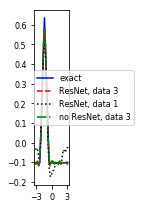

In [39]:
plt.figure(figsize=(2.7,3))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

lines = []
lines += plt.plot(x_pts,data_test_all_tensor[0,IC,:],'-b')
for k in range(3):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(params['model_path']+'.meta')
        saver.restore(sess, params['model_path'])
    
        max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
        # Prediction
        beg = 2*max_shifts_to_stack+3
        end = beg + params['num_shifts']
        tensor_list = ["decoder_outer/outputs:0"]
        for l in np.arange(beg,end):
            tensor_list.append("decoder_outer_"+str(l)+"/outputs:0")
        test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
    test_outputs = np.asarray(test_outputs)

    lines += plt.plot(x_pts,test_outputs[0,IC,:],line_styles[k])
    
plt.xticks([-3,0,3])
#plt.yticks([10**(-2),10**(-1), 10**(0),10**(1)])
#plt.xlabel("Initial Condition")
#plt.ylabel("Prediction Error")
plt.legend(lines,['exact','ResNet, data 3','ResNet, data 1','no ResNet, data 3'],fontsize=8,loc='center',bbox_to_anchor=(1.4,.5))
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/Compare_t0_testIC' + str(IC) + '.eps'
plt.savefig(filename,format='eps')  

INFO:tensorflow:Restoring parameters from ./Burgers_exp28ss/Burgers_Eqn_exp28_2019_10_30_16_51_54_151793_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp30f/Burgers_Eqn_exp30_2019_10_31_06_23_39_735564_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp28pp/Burgers_Eqn_exp28_2019_10_28_11_00_33_377377_model.ckpt


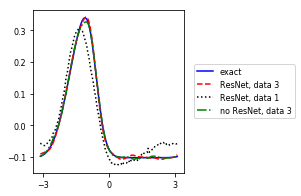

In [38]:
plt.figure(figsize=(2.7,3))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

lines = []
lines += plt.plot(x_pts,data_test_all_tensor[-1,IC,:],'-b')
for k in range(3):
    folder_name = folder_names[k]  # Folder to be created for saved output
    pkl_file = folder_name + BestErrorFile(folder_name)
    
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(params['model_path']+'.meta')
        saver.restore(sess, params['model_path'])
    
        max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
        # Prediction
        beg = 2*max_shifts_to_stack+3
        end = beg + params['num_shifts']
        tensor_list = ["decoder_outer/outputs:0"]
        for l in np.arange(beg,end):
            tensor_list.append("decoder_outer_"+str(l)+"/outputs:0")
        test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
    test_outputs = np.asarray(test_outputs)

    lines += plt.plot(x_pts,test_outputs[-1,IC,:],line_styles[k])
    
plt.xticks([-3,0,3])
#plt.yticks([10**(-2),10**(-1), 10**(0),10**(1)])
#plt.xlabel("Initial Condition")
#plt.ylabel("Prediction Error")
plt.legend(lines,['exact','ResNet, data 3','ResNet, data 1','no ResNet, data 3'],fontsize=8,loc='center',bbox_to_anchor=(1.4,.5))
filename = '../PDEKoopmanAutoencoder/figures/Compare_endtime_testIC' + str(IC) + '.eps'
plt.savefig(filename,format='eps')  

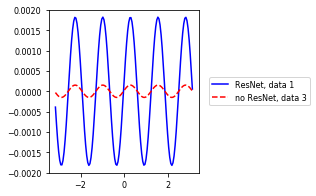

In [34]:
plt.figure(figsize=(2.7,3))
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
lines = []
lines += plt.plot(x_pts,data_test_all_tensor[0,IC,:],'-b')
lines += plt.plot(x_pts,data_test_all_tensor[-1,IC,:],'--r')
plt.legend(lines,['ResNet, data 1','no ResNet, data 3'],fontsize=8,loc='center',bbox_to_anchor=(1.4,.5))
plt.show()

# Find worst prediction

In [58]:
print(np.shape(data_test_all_tensor))
print(np.shape(test_outputs))
exact = data_test_all_tensor
pred = test_outputs

denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=2)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=2)
rel_error = norm_2/denominator # [len_time,n_IC]
traj_error = np.mean(rel_error,axis=0)
print(np.max(traj_error))
print(np.argmax(traj_error))

(51, 5000, 128)
(51, 5000, 128)
0.27804161415287637
3727


# Find best example for comparison figure

In [15]:
# traj_error1 is the mse of each trajectory with good data, ResNet
# traj_error2 is the mse of each trajectory with bad data, ResNet
# traj_error3 is the mse of each trajectory with good data, no ResNet


import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

def pred_loss(exact,pred):

    denominator_nonzero = 0
    denominator = np.mean(np.square(exact),axis=2)+denominator_nonzero
    norm_2 = np.mean(np.square(exact-pred),axis=2)
    rel_error = norm_2/denominator 
    traj_error = np.mean(rel_error,axis=0)
    
    return traj_error


folder_name = 'Burgers_exp28ss/'
pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for l in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(l)+"/outputs:0")
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
test_outputs = np.asarray(test_outputs)
traj_error1 = pred_loss(data_test_all_tensor,test_outputs)

folder_name = 'Burgers_exp30f/'
pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for l in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(l)+"/outputs:0")
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
test_outputs = np.asarray(test_outputs)
traj_error2 = pred_loss(data_test_all_tensor,test_outputs)

folder_name = 'Burgers_exp28pp/'
pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)

tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for l in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(l)+"/outputs:0")
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
test_outputs = np.asarray(test_outputs)
traj_error3 = pred_loss(data_test_all_tensor,test_outputs)

INFO:tensorflow:Restoring parameters from ./Burgers_exp28ss/Burgers_Eqn_exp28_2019_10_30_16_51_54_151793_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp30f/Burgers_Eqn_exp30_2019_10_31_06_23_39_735564_model.ckpt
INFO:tensorflow:Restoring parameters from ./Burgers_exp28pp/Burgers_Eqn_exp28_2019_10_28_11_00_33_377377_model.ckpt


In [19]:
keep_ind = np.nonzero(traj_error1 < traj_error2) 
error1 = traj_error1[keep_ind]
error2 = traj_error2[keep_ind]
error3 = traj_error3[keep_ind]

keep_ind = np.nonzero(error1 < error3) 
error1 = error1[keep_ind]
error2 = error2[keep_ind]
error3 = error3[keep_ind]

print(np.shape(error1))

(1948,)


In [20]:
ind = np.argmax(error2/error1)
print(ind)
print(np.max(error2/error1))
print(error3[ind]/error1[ind])

ind = np.argmax(error3/error1)
print(ind)
print(np.max(error3/error1))
print(error2[ind]/error1[ind])

for ind in range(1941):
    if error2[ind]/error1[ind] > 7:
        if error3[ind]/error1[ind] > 7:
            print(ind)

1641
345.0809908123807
2.2876246976435777
1728
8.218476163825644
5.298030361076502
1617


In [21]:
print(error1[1617])

0.0009440400684113106


In [22]:
print(np.where(traj_error1==0.0009440400684113106))

(array([4254]),)


In [17]:
print(traj_error1[1638])
print(traj_error2[1638])
print(traj_error3[1638])

0.14991770935966708
0.364240548611344
0.8799384879301816
